# Load paired-associates data

load_pal_data.ipynb

In [17]:
# General
import sys
import os
import shutil
import glob
from time import time, strftime
from collections import OrderedDict
od = OrderedDict
from importlib import reload
from glob import glob
import itertools

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries
from ptsa.data.filters import MorletWaveletFilter
import cmlreaders
from cmlreaders import CMLReader

sys.path.append('/home1/dscho/code/general')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
from eeg_plotting import plot_trace, plot_trace2
sys.path.append('/home1/dscho/code/projects/manning_replication')
import manning_utils
import manning_analysis
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import phase_locking
import lfp_synchrony
sys.path.insert(0, '/home1/dscho/code/projects/theta_reinstatement')
import pal_reinstatement as palr
sys.path.insert(0, '/home1/esolo/notebooks/codebases/')
import CML_stim_pipeline
from loc_toolbox import get_region, update_pairs

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']

In [80]:
f = '/home1/dscho/projects/theta_reinstatement/data/metadata/r1_df.pkl'
dio.save_pickle(ix, f)

Saved /home1/dscho/projects/theta_reinstatement/data/metadata/r1_df.pkl


In [18]:
# Load paired-associated data.
ix = CMLReader.get_data_index("r1")
expmt = 'PAL1'
ix_pal = ix.query("(experiment=='{}')".format(expmt))
pal_subjs = ix_pal.groupby('subject').agg({'session': lambda x: list(x)})
print('{} subjs, {} sessions, {}-{} sessions/subj (median = {})'
      .format(len(pal_subjs), len(ix_pal), 
              np.min(pal_subjs['session'].apply(lambda x: len(x))),
              np.max(pal_subjs['session'].apply(lambda x: len(x))),
              np.median(pal_subjs['session'].apply(lambda x: len(x)))))

72 subjs, 151 sessions, 1-5 sessions/subj (median = 2.0)


In [19]:
# Get subject info.
subjs = []
bad_subjs = []
n_sessions = 0
for subj in pal_subjs.index.tolist():
    sessions = ix_pal.query("(subject=='{}')".format(subj)).session.tolist()
    mont = ix_pal.query("(subject=='{}')".format(subj)).montage.iat[0]
    lclz = ix_pal.query("(subject=='{}')".format(subj)).localization.iat[0]

    n_mont = len(np.unique(ix_pal.query("(subject=='{}')".format(subj)).montage))
    n_lclz = len(np.unique(ix_pal.query("(subject=='{}')".format(subj)).localization))
    if not ((n_mont==1) & (n_lclz==1)):
        bad_subjs.append(bad_subjs)
#         print('**', subj, mont, lclz, sessions)
    else:
        subjs.append(subj)
#         print(subj, mont, lclz, sessions)
        n_sessions += len(sessions)
        
print('{}/{} good subjs and {} good sessions'.format(len(pal_subjs.index.tolist()) - len(bad_subjs), len(pal_subjs.index.tolist()), n_sessions))

70/72 good subjs and 144 good sessions


In [410]:
# Select a single subject and session to analyze.
# Done: 10
subj = pal_subjs.index.tolist()[1]
sess = pal_subjs.loc[subj]['session'][0]
subj_sess = '{}_ses{}'.format(subj, sess)
print(subj_sess, '{} sessions total'.format(len(pal_subjs.loc[subj]['session'])))
reader = CMLReader(subj, expmt, sess)

R1002P_ses0 3 sessions total


In [135]:
reload(palr)

<module 'pal_reinstatement' from '/home1/dscho/code/projects/theta_reinstatement/pal_reinstatement.py'>

In [136]:
%%capture cap

# Process and save epoched power and cosine sim
# matrices for each session.
start_time = time()

recall_pct_thresh = 100/6
recall_n_thresh = 20
verbose = True
overwrite=False

failed_subjs = []
i = 0
for subj in subjs:
    for sess in pal_subjs.loc[subj]['session']:
        print('\n*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*\n')
        try:
            palr.run_sess(subj, 
                          sess, 
                          recall_pct_thresh=recall_pct_thresh, 
                          recall_n_thresh=recall_n_thresh, 
                          verbose=verbose,
                          overwrite=overwrite)
        except:
            print('FAILED SESSION {} {}'.format(subj, sess))
            failed_subjs.append([subj, sess])
        
        print('\n{} sessions done; {:.2f} s elapsed\n'.format(i, time() - start_time))
        i += 1
            
print('{} failed subjs'.format(len(failed_subjs)), end='\n\n')

print('Done in {:.2f} s'.format(time() - start_time))

In [137]:
# -----------------------------------
# Save cell output.
fname = '/home1/dscho/logs/load_pal_data-{}.txt'.format(strftime('%m_%d_%Y-%H_%M_%S'))
with open(fname, 'a') as f:
    f.write('*-*-*-*-*\nstdout\n*-*-*-*-*\n\n')
    f.write(cap.stdout)
    f.write('\n------\n-----\n----\n---\n--\n-\n-\n--\n---\n----\n-----\n------\n')
    f.write('\n*-*-*-*-*\nstderr\n*-*-*-*-*\n\n')
    f.write(cap.stderr)
    f.write('\n')

# Load behavioral events

In [415]:
events = reader.load('events')
_ = palr.desc_events(events)

n_events : 1348
n_lists : 25
n_study_pairs : 150
n_test_probes : 150
n_rec_events : 169
n_correct : 91
pct_correct : 60.7%
n_pass : 0
pct_pass : 0.0%
n_intrusions : 5
pct_intrusions : 3.3%


In [445]:
def trial_pairs2(events, list_, pair_type='all'):
    """ Return info on all encoding, retrieval pairs for a given list.
    
    Parameters
    ----------
    events : pd.DataFrame
        The behavioral events.
    list_ : list or np.ndarray
        The word list to operate on (events['list'] values).
    pair_type : str
        'enc-rec' pairs each encoding item with each retrieval item.
        'enc-enc' pairs each encoding item with each other encoding item.
        'rec-rec' pairs each recall item with each other recall item.
        'all' includes each of the above categories.
    
    Returns
    -------
    pd.DataFrame
    """
    enc_inds = events.loc[(events['list']==list_) & (events['type']=='STUDY_PAIR')].index.tolist()
    rec_inds = events.loc[(events['list']==list_) & (events['type']=='REC_EVENT')].index.tolist()
    if (len(enc_inds) == 0) or (len(rec_inds) == 0):
        return None
    
    # Get the index pairs.
    if pair_type == 'enc-rec':
        idx_pairs = np.array([(x, y) for x in enc_inds for y in rec_inds])
        idx_labs = np.array(['enc-rec' for _ in idx_pairs])
    elif pair_type == 'enc-enc':
        idx_pairs = np.array([(x, y) for x in enc_inds for y in enc_inds if x>y])
        idx_labs = np.array(['enc-enc' for _ in idx_pairs])
    elif pair_type == 'rec-rec':
        idx_pairs = np.array([(x, y) for x in rec_inds for y in rec_inds if x>y])
        idx_labs = np.array(['rec-rec' for _ in idx_pairs])
    elif pair_type == 'all':
        idx_pairs = np.concatenate((np.array([(x, y) for x in enc_inds for y in rec_inds]),
                                    np.array([(x, y) for x in enc_inds for y in enc_inds if x<y]),
                                    np.array([(x, y) for x in rec_inds for y in rec_inds if x<y])))
        idx_labs = np.concatenate((['enc-rec' for _ in np.array([(x, y) for x in enc_inds for y in rec_inds])],
                                    ['enc-enc' for _ in np.array([(x, y) for x in enc_inds for y in enc_inds if x<y])],
                                    ['rec-rec' for _ in np.array([(x, y) for x in rec_inds for y in rec_inds if x<y])]))
        
    eegoffsets = idx_pair_vals(events, idx_pairs, 'eegoffset')
    correct_events = idx_pair_vals(events, idx_pairs, 'correct')
    
    # Calculate the serial position lag between each (enc, rec) pair.
    # Lag == 0 means we are comparing a probe to its actual study pair.
    # Lag < 0 means we are comparing a probe to a study pair that
    #         appeared before the probe in the study list.
    # Lag > 0 means we are comparing a probe to a study pair that 
    #         appeared after the probe in the study list.
    serial_pos = idx_pair_vals(events, idx_pairs, 'serialpos')
    serial_pos_lag = serial_pos[:, 0] - serial_pos[:, 1]
    probe_pos = idx_pair_vals(events, idx_pairs, 'probepos')
    probe_pos_lag = probe_pos[:, 0] - probe_pos[:, 1]
    event_pairs = pd.DataFrame(od([('idx_enc', idx_pairs[:, 0]),
                                   ('idx_rec', idx_pairs[:, 1]),
                                   ('pair_type', idx_labs),
                                   ('eegoffset_enc', eegoffsets[:, 0]),
                                   ('eegoffset_rec', eegoffsets[:, 1]),
                                   ('list', [list_ for x in range(idx_pairs.shape[0])]),
                                   ('serialpos_enc', serial_pos[:, 0]),
                                   ('serialpos_rec', serial_pos[:, 1]),
                                   ('serialpos_lag', serial_pos_lag),
                                   ('probepos_enc', probe_pos[:, 0]),
                                   ('probepos_rec', probe_pos[:, 1]),
                                   ('probepos_lag', probe_pos_lag),
                                   ('correct_enc', correct_events[:, 0]),
                                   ('correct_rec', correct_events[:, 1]),
                                   ('intrusion_rec', idx_pair_vals(events, idx_pairs, 'intrusion')[:, 1]),
                                   ('resp_pass', idx_pair_vals(events, idx_pairs, 'resp_pass')[:, 1])]))
    return event_pairs

In [20]:
def study_list_isis(events):
    """Print mean +/- stdev inter-stimulus intervals across lists."""
    def describe(arr):
        return np.mean(arr), np.std(arr), np.min(arr), np.max(arr)
    
    print('Encoding durations:',
          ('{:.1f} +/- {:.1f}ms (min={}, max={}) between study orient and study pair onset'
           .format(*describe(np.concatenate([np.diff(events.loc[(events['list']==list_)].query("(type==['STUDY_PAIR', 'STUDY_ORIENT'])")['mstime'])[::2] for list_ in lists])))),
          ('{:.1f} +/- {:.1f}ms (min={}, max={}) duration each study pair is shown'
           .format(*describe(np.concatenate([np.diff(events.loc[(events['list']==list_)].query("(type==['STUDY_PAIR', 'STUDY_ORIENT'])")['mstime'])[1::2] for list_ in lists])))),
          'next study orient immediately follows study pair offset',
          sep='\n', end='\n\n')

    print('Recall durations:',
          ('{:.1f} +/- {:.1f}ms (min={}, max={}) between test orient and test probe onset'
           .format(*describe([np.diff(events.loc[(events['list']==list_)].query("(type==['TEST_ORIENT', 'REC_START', 'REC_END'])")['mstime'])[::3] for list_ in lists]))),
          ('{:.1f} +/- {:.1f}ms (min={}, max={}) duration each test probe is shown'
           .format(*describe([np.diff(events.loc[(events['list']==list_)].query("(type==['TEST_ORIENT', 'REC_START', 'REC_END'])")['mstime'])[1::3] for list_ in lists]))),
          ('{:.1f} +/- {:.1f}ms (min={}, max={}) between test orient and test probe onset'
           .format(*describe([np.diff(events.loc[(events['list']==list_)].query("(type==['TEST_ORIENT', 'REC_START', 'REC_END'])")['mstime'])[2::3] for list_ in lists]))),
          sep='\n')

def idx_pair_vals(events, idx_pairs, col_name):
    """Return column values for a list of event index pairs.
    
    Parameters
    ----------
    events : pd.DataFrame
        The behavioral events.
    idx_pairs : np.ndarray
        An n x 2 array of (encoding, retrieval)
        event index pairs.
    col_name : str
        The events column to grab values from.
        
    Returns
    -------
    np.ndarray
        An array in the shape of idx_pairs
        containing the corresponding col_name
        data.
    """
    return np.array([[events.at[idx_pairs[iPair, 0], col_name], 
                      events.at[idx_pairs[iPair, 1], col_name]]
                     for iPair in range(idx_pairs.shape[0])])

def enc_trial_pairs():
    """ Return info on all encoding item-to-item pairs for a given list.
    
    Parameters
    ----------
    events : pd.DataFrame
        The behavioral events.
    list_ : list or np.ndarray
        The word list to operate on (events['list'] values).
    
    Returns
    -------
    pd.DataFrame
    """
    enc_inds = events.loc[(events['list']==list_) & (events['type']=='STUDY_PAIR')].index.tolist()
    if (len(enc_inds) == 0):
        return None
    
    enc_pairs = np.array([(x, y) for x in enc_inds for y in enc_inds if x>y])
    eegoffsets = idx_pair_vals(events, enc_pairs, 'eegoffset')
    correct_events = idx_pair_vals(events, enc_pairs, 'correct')
    

def trial_pairs(events, list_):
    """ Return info on all encoding, retrieval pairs for a given list.
    
    Parameters
    ----------
    events : pd.DataFrame
        The behavioral events.
    list_ : list or np.ndarray
        The word list to operate on (events['list'] values).
    
    Returns
    -------
    pd.DataFrame
    """
    enc_inds = events.loc[(events['list']==list_) & (events['type']=='STUDY_PAIR')].index.tolist()
    rec_inds = events.loc[(events['list']==list_) & (events['type']=='REC_EVENT')].index.tolist()
    if (len(enc_inds) == 0) or (len(rec_inds) == 0):
        return None
    
    enc_rec_pairs = np.array([[(x, y) for x in enc_inds] for y in rec_inds])
    enc_rec_pairs = enc_rec_pairs.reshape((np.prod(enc_rec_pairs.shape[:-1]), enc_rec_pairs.shape[-1]))
    eegoffsets = idx_pair_vals(events, enc_rec_pairs, 'eegoffset')
    correct_events = idx_pair_vals(events, enc_rec_pairs, 'correct')
    
    # Calculate the serial position lag between each (enc, rec) pair.
    # Lag == 0 means we are comparing a probe to its actual study pair.
    # Lag < 0 means we are comparing a probe to a study pair that
    #         appeared before the probe in the study list.
    # Lag > 0 means we are comparing a probe to a study pair that 
    #         appeared after the probe in the study list.
    serial_pos = idx_pair_vals(events, enc_rec_pairs, 'serialpos')
    enc_rec_lags = serial_pos[:, 0] - serial_pos[:, 1]
    event_pairs = pd.DataFrame(od([('idx_enc', enc_rec_pairs[:, 0]),
                                   ('idx_rec', enc_rec_pairs[:, 1]),
                                   ('eegoffset_enc', eegoffsets[:, 0]),
                                   ('eegoffset_rec', eegoffsets[:, 1]),
                                   ('list', [list_ for x in range(enc_rec_pairs.shape[0])]),
                                   ('serialpos_enc', serial_pos[:, 0]),
                                   ('serialpos_rec', serial_pos[:, 1]),
                                   ('lag', enc_rec_lags),
                                   ('correct_enc', correct_events[:, 0]),
                                   ('correct_rec', correct_events[:, 1]),
                                   ('intrusion_rec', idx_pair_vals(events, enc_rec_pairs, 'intrusion')[:, 1]),
                                   ('resp_pass', idx_pair_vals(events, enc_rec_pairs, 'resp_pass')[:, 1])]))
    return event_pairs

def desc_events(events):
    """Describe behavioral events."""
    study_pairs = len(events.query("(type=='STUDY_PAIR')"))
    test_probes = len(events.query("(type=='TEST_PROBE')"))
    rec_events = len(events.query("(type=='REC_EVENT')"))

    print('{} events'.format(len(events)),
          '{} lists'.format(len(np.array([i for i in pd.unique(events_['list']) if (i>0)]))),
          '{} study pairs'.format(study_pairs),
          '{} test probes'.format(test_probes),
          '{} rec_events'.format(rec_events), 
          sep='\n', end='\n\n')

    corr_recs = np.sum(events.query("(type=='REC_EVENT')")['correct'])
    resp_pass = np.sum(events.query("(type=='REC_EVENT')")['resp_pass'])
    intrusions = aop.unique(events.query("(type=='REC_EVENT')")['intrusion'], sort=False)
    print('{} ({:.1f}%) correct recalls'.format(corr_recs, 100*corr_recs/test_probes), end='\n')
    print('{} ({:.1f}%) pass responses'.format(resp_pass, 100*resp_pass/test_probes), end='\n\n')
    print('Intrusions:', intrusions, sep='\n')

In [699]:
events = reader.load('events')
print('{} events'.format(len(events)))

# Determine all possible within-list pairs between encoding and recall events.
events_ = events.query("(type==['STUDY_PAIR', 'REC_EVENT'])").copy()
lists = np.array([i for i in pd.unique(events_['list']) if (i>0)])
event_pairs = pd.concat([trial_pairs(events_, list_) for list_ in lists])
print('{} event pairs'.format(len(event_pairs)))

# Add columns for the relative positions of each encoding/retrieval event within the session.
idx_enc_pos = {v:i for i, v in enumerate(event_pairs['idx_enc'].unique())}
idx_rec_pos = {v:i for i, v in enumerate(event_pairs['idx_rec'].unique())}
event_pairs.insert(1, 'idx_enc_pos', event_pairs['idx_enc'].apply(lambda x: idx_enc_pos[x]))
event_pairs.insert(3, 'idx_rec_pos', event_pairs['idx_rec'].apply(lambda x: idx_rec_pos[x]))

1348 events
1014 event pairs


In [700]:
study_pairs = len(events.query("(type=='STUDY_PAIR')"))
test_probes = len(events.query("(type=='TEST_PROBE')"))
rec_events = len(events.query("(type=='REC_EVENT')"))

print('{} events'.format(len(events)),
      '{} lists'.format(len(np.array([i for i in pd.unique(events_['list']) if (i>0)]))),
      '{} study pairs'.format(study_pairs),
      '{} test probes'.format(test_probes),
      '{} rec_events'.format(rec_events), 
      sep='\n', end='\n\n')

corr_recs = np.sum(events.query("(type=='REC_EVENT')")['correct'])
resp_pass = np.sum(events.query("(type=='REC_EVENT')")['resp_pass'])
intrusions = aop.unique(events.query("(type=='REC_EVENT')")['intrusion'], sort=False)
print('{} ({:.1f}%) correct recalls'.format(corr_recs, 100*corr_recs/test_probes), end='\n')
print('{} ({:.1f}%) pass responses'.format(resp_pass, 100*resp_pass/test_probes), end='\n\n')
print('Intrusions:', intrusions, sep='\n')

1348 events
25 lists
150 study pairs
150 test probes
169 rec_events

91 (60.7%) correct recalls
0 (0.0%) pass responses

Intrusions:
 0    164
-1      2
 2      1
 1      2
Name: intrusion, dtype: int64


In [505]:
print(aop.unique(events['type'], sort=False))

REC_END           150
STUDY_ORIENT      150
TEST_START         25
MATH_START         25
TEST_PROBE        150
PROB              126
SESS_START          1
ENCODING_START     25
TEST_ORIENT       150
STOP               26
REC_EVENT         169
REC_START         150
MATH_END           25
START              26
STUDY_PAIR        150
Name: type, dtype: int64


In [512]:
study_list_isis(events)

Encoding durations:
911.9 +/- 70.2ms (min=768, max=1017) between study orient and study pair onset
5025.7 +/- 8.0ms (min=5017, max=5035) duration each study pair is shown
next study orient immediately follows study pair offset

Recall durations:
905.9 +/- 74.4ms (min=785, max=1035) between test orient and test probe onset
5013.5 +/- 6.3ms (min=4999, max=5028) duration each test probe is shown
12.8 +/- 4.3ms (min=6, max=23) between test orient and test probe onset


In [9]:
aop.unique(event_pairs['lag']).sort_index()

-5     25
-4     50
-3     75
-2    100
-1    125
 0    150
 1    125
 2    100
 3     75
 4     50
 5     25
Name: lag, dtype: int64

# Load EEG

In [167]:
def get_pairs(subj, expmt):
    """Get the bipolar pairs DataFrame for a given subject and experiment.
    
    Also gets any MTL labels and flags bad electrodes.
    
    Returns
    -------
    pairs : pandas.core.frame.DataFrame
        Info on the bipolar electrode pairs. 
    pairs_keep_inds : list
        Electrodes flagged for removal due to epileptiform activity
        or the absence of ROI labeling.  
    """
    cmlpipe = CML_stim_pipeline.cml_pipeline(subj, expmt) 
    cmlpipe.set_elecs(type='bi', flag_bad_elecs=True)
    pairs = cmlpipe.elecs
    if 'bad_elecs' not in pairs.columns: 
        pairs['bad_elecs'] = False
    if 'electrode_categories' not in pairs.columns:
        pairs['electrode_categories'] = ''

    # Load localization for MTL subregions
    pairs['roi'] = pairs['ind.region'].astype(str)
    pairs['hem'] = pairs['ind.x'].apply(lambda x: 'L' if x<0 else 'R')
    try:
        lclz_df = cmlpipe.reader.load('localization')
        pairs = update_pairs(lclz_df, pairs)
    except FileNotFoundError:
        print('{} {} missing localization file'.format(subj, expmt))
    if ('das.region' in pairs.columns) and not ('stein.region' in pairs.columns):
        pairs.rename(columns={'das.region': 'stein.region'}, inplace=True)
    if 'stein.region' in pairs.columns:
        hpc_labels = ['CA1', 'CA2', 'CA3', 'DG', 'Sub', 'SUB']
        ec_labels = ['EC', 'ERC']
        pairs['stein.region'] = pairs['stein.region'].apply(lambda x: str(x).replace('"', ''))
        pairs.loc[pairs['stein.region'].isin(hpc_labels), 'roi'] = 'hippocampal'
        pairs.loc[pairs['stein.region'].isin(ec_labels), 'roi'] = 'entorhinal'
    else:
        print('{} {} missing MTL mapping'.format(subj, expmt))
    
    pairs_keep_inds = pairs.query("(bad_elecs==False) & (roi!={})".format(['None', 'unknown'])).index.tolist()
    
    return pairs, pairs_keep_inds

def get_trial_wins(enc_start=-1000, # ms
                   enc_stop=4000,
                   rec_start=-4000,
                   rec_stop=1000,
                   lowest_freq=2, # Hz
                   sr=500,
                   n_cycles=6,
                   endpoint=True,
                   verbose=True):
    """Return EEG windows for encoding/retrieval trials.
    
    Given with and without the buffer added.
    """
    # Define trial windows for wavelet analyses.
    if endpoint:
        wins = od([('enc', (enc_start, enc_stop+1)),
                   ('rec', (rec_start, rec_stop+1))])
    else:
        wins = od([('enc', (enc_start, enc_stop)),
                   ('rec', (rec_start, rec_stop))])
    
    buff_ms = int((n_cycles * 1000/lowest_freq) / 2)
    buff_samp = int(buff_ms * (sr/1000))
    
    wins_full = od([])
    for k, v in wins.items():
        wins_full[k] = (wins[k][0]-buff_ms, wins[k][1]+buff_ms)
    
    if verbose:
        print('Without buffer:')
        for k in wins:
            print('{}: {} to {} ms'.format(k, wins[k][0], wins[k][1]))
        print('\nWith buffer:')
        for k in wins:
            print('{}: {} to {} ms'.format(k, wins_full[k][0], wins_full[k][1]))
        
    return wins, wins_full, buff_ms, buff_samp

def reader_load_eeg(reader, 
                    events=None, 
                    wins_full=None, 
                    trial_type=['enc', 'rec'], 
                    list_='all', 
                    presumed_sr=None,
                    verbose=True):
    """Return epoched eeg for encoding/retrieval events.
    
    If only the reader is passed, returns eeg across all
    channels for the whole session.
    """
    if events is None:
        eeg = reader.load_eeg(scheme=pairs)
        eeg.data = np.squeeze(eeg.data)
        if presumed_sr:
            assert presumed_sr == eeg.samplerate
        if verbose:
            print('{} channels'.format(eeg.data.shape[0]), 
                  '{} timepoints'.format(eeg.data.shape[1]),
                  sep='\n', end='\n\n')
            print('{} Hz sr'.format(eeg.samplerate))
        return eeg    
    
    # Format inputs.
    if isinstance(trial_type, str):
        trial_type = [trial_type]
    if list_ == 'all':
        lists = np.array([i for i in pd.unique(events_['list']) if (i>0)])
    else:
        lists = [list_]
        
    # Get the EEG.
    eeg = od([])
    if 'enc' in trial_type:
        eeg['enc'] = reader.load_eeg(events=events.loc[(events['type']=='STUDY_PAIR') & (np.isin(events['list'], lists))], 
                                     rel_start=wins_full['enc'][0], rel_stop=wins_full['enc'][1],
                                     scheme=pairs)
    if 'rec' in trial_type:
        eeg['rec'] = reader.load_eeg(events=events_.loc[(events['type']=='REC_EVENT') & (np.isin(events['list'], lists))],
                                     rel_start=wins_full['rec'][0], rel_stop=wins_full['rec'][1],
                                     scheme=pairs)
    for k in eeg:
        eeg[k].data = np.squeeze(eeg[k].data)
        if presumed_sr:
            assert presumed_sr == eeg[k].samplerate
            
    if verbose:
        for k in eeg:
            print('{}:'.format(k))
            if len(eeg[k].data.shape) == 2:
                print('{} channels'.format(eeg[k].data.shape[0]), 
                      '{} timepoints'.format(eeg[k].data.shape[1]),
                      sep='\n', end='\n\n')
            elif len(eeg[k].data.shape) == 3:
                print('{} trials'.format(eeg[k].data.shape[0]),
                      '{} channels'.format(eeg[k].data.shape[1]), 
                      '{} timepoints over {:.0f} ms'.format(eeg[k].data.shape[2], 1000 * eeg[k].data.shape[2]/eeg[k].samplerate),
                      sep='\n', end='\n\n')
        print('{} Hz sr'.format(eeg[k].samplerate))
    return eeg

In [703]:
print('Subj: {}\nSess: {}\nExperiment: {}\n'.format(subj, sess, expmt))
pairs, pairs_keep_inds = get_pairs(subj, expmt)
print('----------------------------------------\npairs shape: {}; keep {} pairs\n'.format(pairs.shape, len(pairs_keep_inds)))
print('Regions (pre removal):', pairs['roi'].value_counts(dropna=False), '', sep='\n')
print('Bad elecs:', pairs['electrode_categories'].value_counts(dropna=False), '', sep='\n')

pairs = pairs.loc[pairs_keep_inds].copy()
print('Regions (post removal):', pairs['roi'].value_counts(dropna=False), '', sep='\n')

Subj: R1002P
Sess: 0
Experiment: PAL1



/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1002P/tal/R1002P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


R1002P PAL1 missing localization file
----------------------------------------
pairs shape: (58, 43); keep 31 pairs

Regions (pre removal):
None                    12
inferiortemporal        11
rostralmiddlefrontal     9
precentral               5
parsorbitalis            4
lateralorbitofrontal     3
caudalmiddlefrontal      3
temporalpole             3
parstriangularis         3
middletemporal           2
parahippocampal          2
frontalpole              1
Name: roi, dtype: int64

Bad elecs:
              43
interictal    14
soz            1
Name: electrode_categories, dtype: int64

Regions (post removal):
rostralmiddlefrontal    9
precentral              5
parsorbitalis           4
lateralorbitofrontal    3
parstriangularis        3
caudalmiddlefrontal     3
parahippocampal         2
inferiortemporal        1
frontalpole             1
Name: roi, dtype: int64



/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /data10/RAM/subjects/R1002P/docs/electrode_categories.txt
/scratch/pwanda/electrode_categories/electrode_categories_R1002P.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


In [168]:
# Define frequencies for wavelet analyses.
freqs = np.logspace(np.log2(2), np.log2(100), 46, endpoint=True, base=2)
print('{} freqs from {:.0f}-{:.0f}Hz'.format(len(freqs), np.min(freqs), np.max(freqs)))

freq_bands = od([('theta', (3.5, 8)),
                 ('alpha', (8, 12)),
                 ('beta', (13, 25)),
                 ('lgamma', (30, 58)),
                 ('hgamma', (62, 100.5))])

46 freqs from 2-100Hz


In [169]:
# Define trial windows for wavelet analyses.
sr = 500 # Hz
n_cycles = 6
wins, wins_full, buff_ms, buff_samp = get_trial_wins(sr=sr, n_cycles=n_cycles, endpoint=True)

Without buffer:
enc: -1000 to 4001 ms
rec: -4000 to 1001 ms

With buffer:
enc: -2500 to 5501 ms
rec: -5500 to 2501 ms


In [704]:
# Define unique names for each trial.
# (l1_s1 = list 1 study pair 1; l4_p2 = list 4 recall probe 2)
trials = od([])
trials['enc'] = events_.loc[(events['type']=='STUDY_PAIR')].apply(lambda x: 'l{}_s{}'.format(x['list'], x['probepos']), axis=1).tolist()
trials['rec'] = events_.loc[(events['type']=='REC_EVENT')].apply(lambda x: 'l{}_p{}'.format(x['list'], x['probepos']), axis=1).tolist()

In [87]:
# Load trial-wise eeg.
list_ = lists[0]
print('List {}\n'.format(list_))
eeg = reader_load_eeg(reader, events, wins_full, list_=list_, presumed_sr=sr)

List 1

enc:
6 trials
56 channels
4000 timepoints over 8000 ms

rec:
6 trials
56 channels
4000 timepoints over 8000 ms

500 Hz sr


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1042M/experiments/PAL1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1042M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


In [16]:
for k in eeg:
    print(k, eeg[k].data[:, :, :].shape, eeg[k].data[:, :, buff_samp:-buff_samp].shape )

enc (6, 56, 4000) (6, 56, 2500)
rec (6, 56, 4000) (6, 56, 2500)


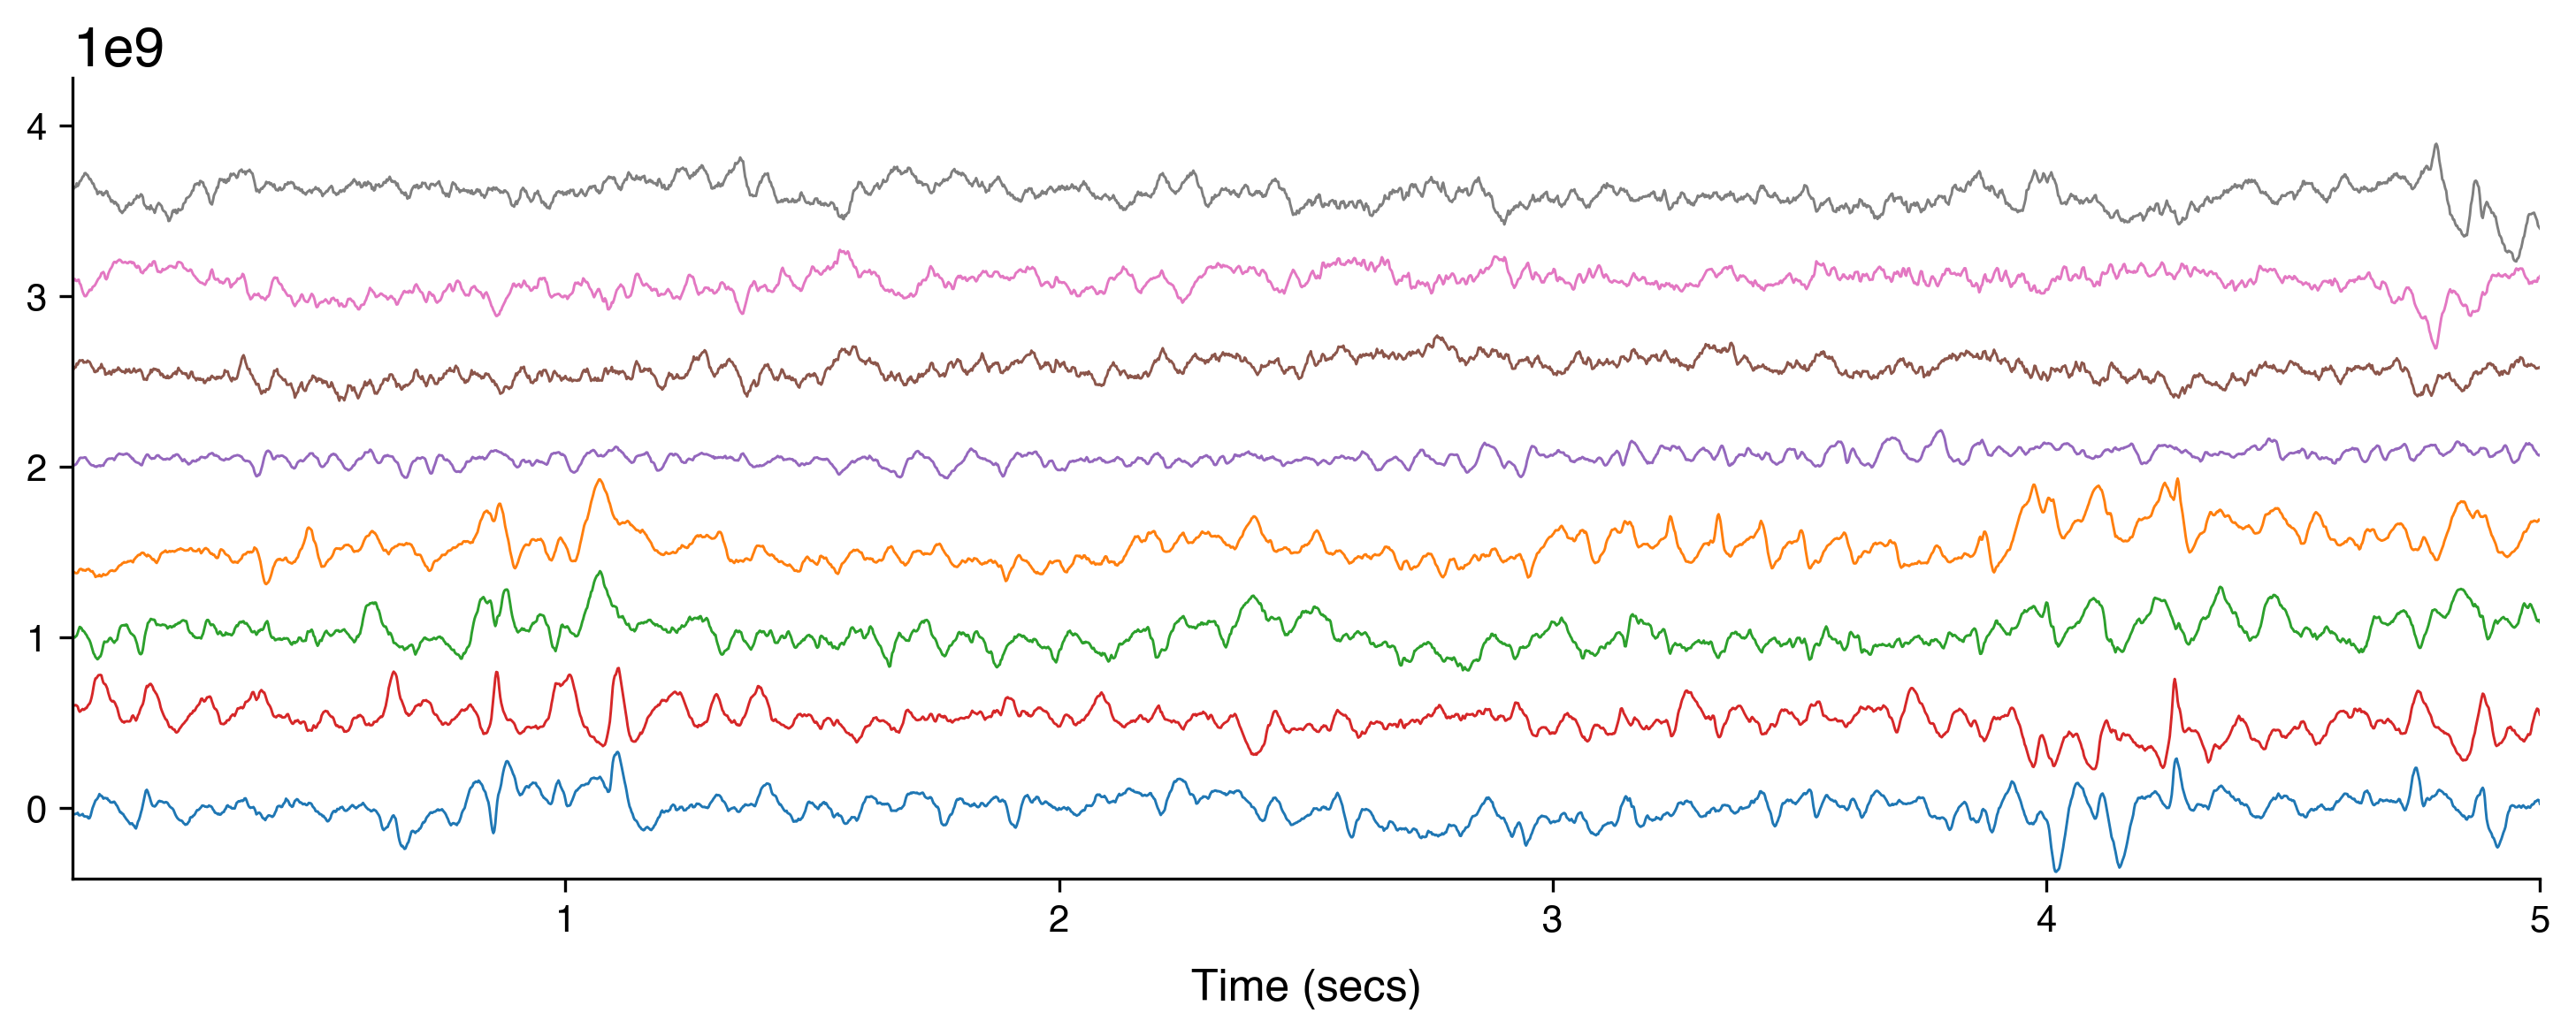

In [794]:
fig, ax = plot_trace(eeg['enc'].data[0, 8:16, buff_samp:-buff_samp], x_units='secs', sampling_rate=sr)

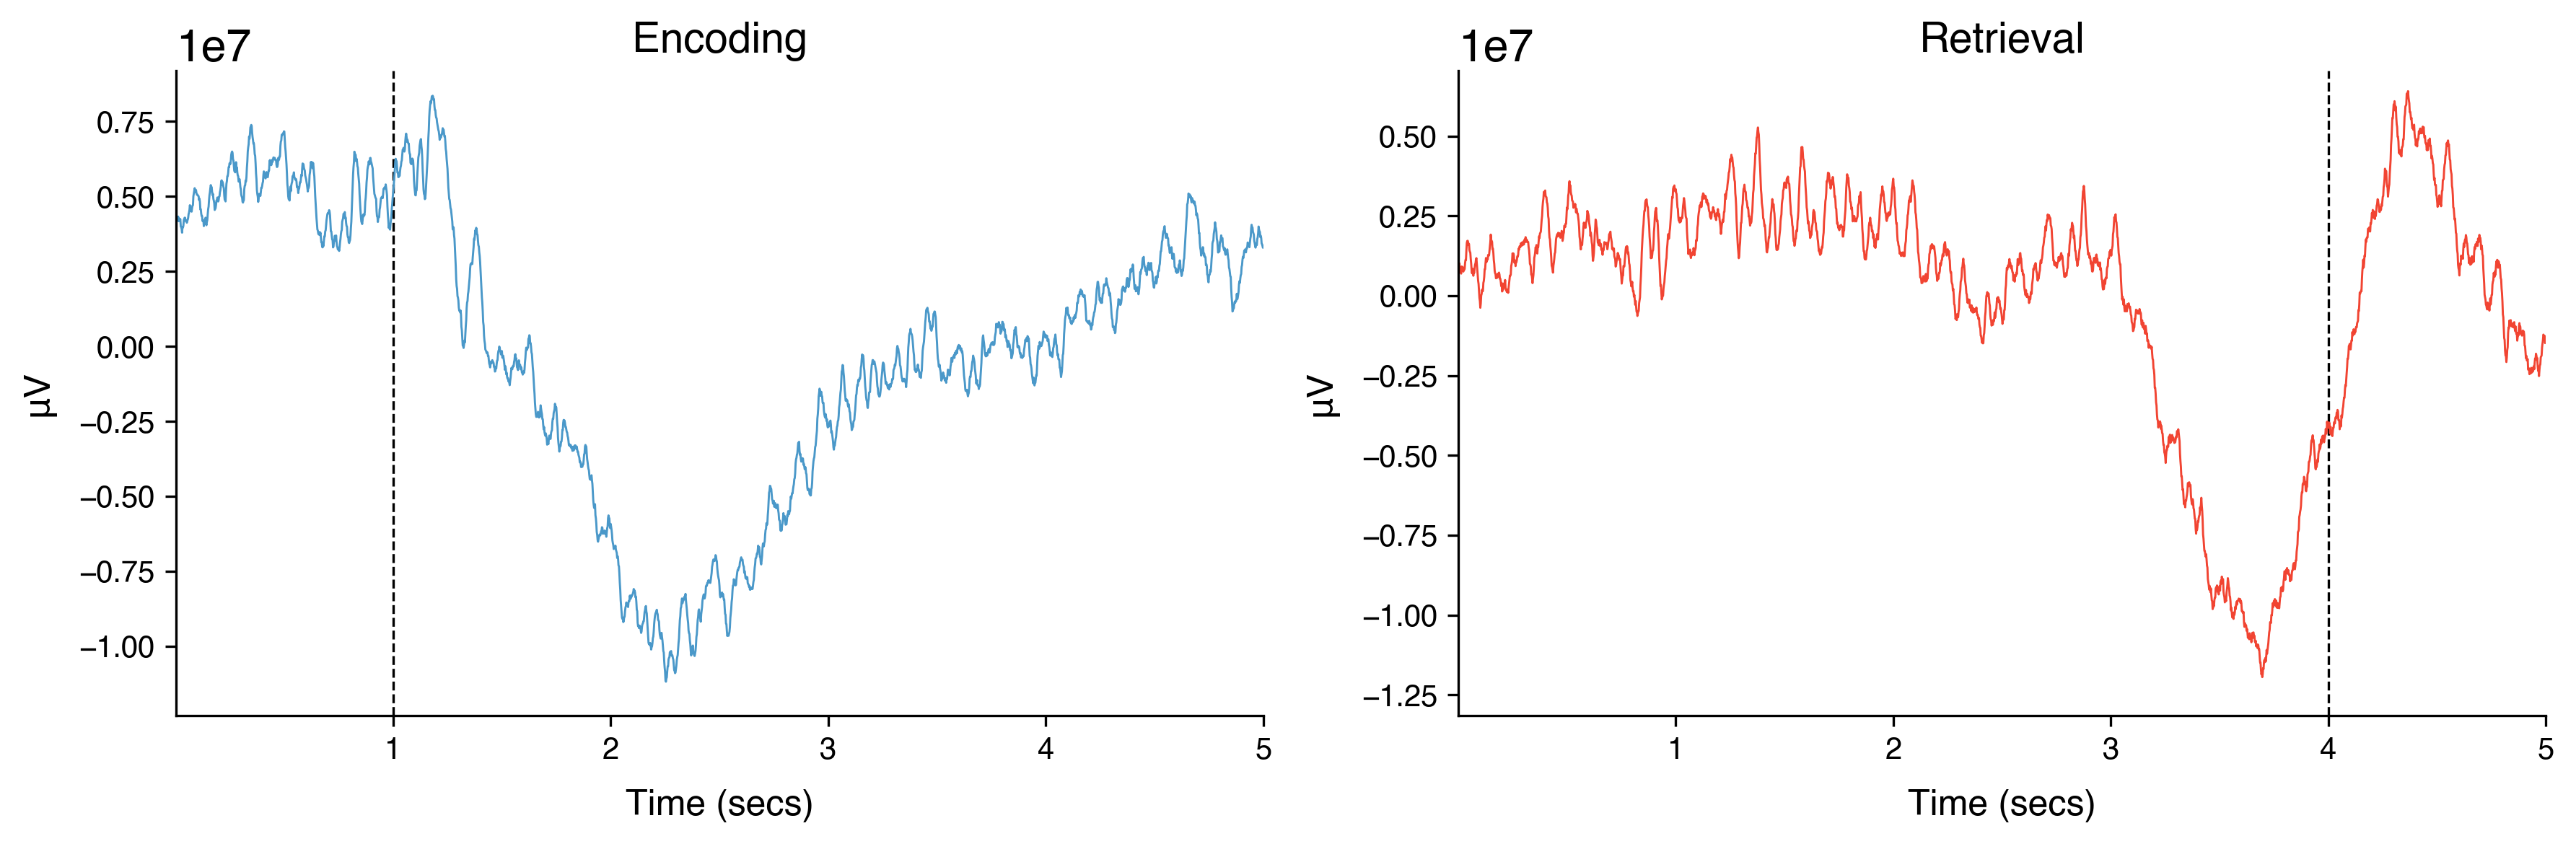

In [675]:
# Examine encoding and retrieval ERPs averaged across all channels and events.
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

figfontsize = 14

i = 0
plot_trace2(np.mean(eeg['enc'].data, axis=(0, 1))[buff_samp:-buff_samp], colors=colors,
            x_units='secs', sampling_rate=sr, nwin=1, figsize=(12, 4), fig=fig, ax=ax[i])
ax[i].axvline(1, color='k', linestyle='--', linewidth=0.8, zorder=0)
ax[i].set_title('Encoding', y=1.02, fontsize=figfontsize)

i = 1
plot_trace2(np.mean(eeg['rec'].data, axis=(0, 1))[buff_samp:-buff_samp], colors=colors[1:],
            x_units='secs', sampling_rate=sr, nwin=1, figsize=(12, 4), fig=fig, ax=ax[i])
ax[i].axvline(4, color='k', linestyle='--', linewidth=0.8, zorder=0)
ax[i].set_title('Retrieval', y=1.02, fontsize=figfontsize)

fig.tight_layout()

# Calculate power and phase

In [172]:
def get_epoch_inds(wins,
                   sr,
                   buff_samp, # samples
                   spacing=100, # ms
                   verbose=True): 
    """Return indices for each """
    spacing_samp = np.int(spacing * (sr/1000))
    
    epoch_inds = od([])
    for k in wins:
        win_size = np.int((wins[k][1] - wins[k][0]) * (sr/1000))
        epoch_inds[k] = buff_samp + np.arange(0, win_size, spacing_samp)
         
    if verbose:
        for k in epoch_inds:
            print('{}: {} epochs ({}, {}, ..., {})'.format(k, len(epoch_inds[k]), epoch_inds[k][0], epoch_inds[k][1], epoch_inds[k][-1]))
    return epoch_inds

def epoch_pows(ts,
               freqs,
               freq_bands,
               timebin_inds,
               timebin_size=500, # ms
               width=6,
               log_power=True, 
               overwrite=False,
               savedir='/home1/dscho/projects/theta_reinstatement/data/morlet/power',
               output_ftag='',
               verbose=False):
    """Return epoched powers within each trial.
    
    Output array shape is trial x chan x freq x time.
    """
    # Get the output file name.
    fstr = ('-width{}-{:.0f}to{:.0f}Hz-{}freqs'
            .format(width, min(freqs), max(freqs), len(freqs)))
    if log_power:
        fstr += '-log10'
    fname = '{}-power{}-{}.pkl'.format(ts.name, fstr, output_ftag)
    power_file = os.path.join(savedir, fname)
    
    # Load the output file if it exists.
    if os.path.exists(power_file) and not overwrite:
        if verbose:
            print('Loading power:\n\t{}'.format(power_file))
        power = dio.open_pickle(power_file)
        return power
        
    # Wavelet filter the EEG data.
    if verbose:
        print('Calculating power...')
    power = MorletWaveletFilter(ts, freqs, width=width, output=['power'], verbose=False).filter()
    
    # Convert data type.
    power = power.data.astype(np.float32)
    
    # Log transform power values.
    if log_power:
        power = np.log10(power)
        
    # Average powers within each frequency band.
    power = np.array([np.mean(power[np.where((freqs>=v[0]) & (freqs<v[1]))[0], :, :, :], axis=0)
                      for v in freq_bands.values()])
        
    # Transpose data shape.
    power = power.transpose(1, 2, 0, 3) # trial x chan x freq x time
    
    # Calculate mean power within each time window.
    if verbose:
        print('Making power time bins...')
    power = np.mean(aop.rolling_window(power, timebin_size)[:, :, :, timebin_inds, :], axis=-1) # trial x freq x chan x timebin
    
    # Save the data.
    if savedir:
        dio.save_pickle(power, power_file, verbose)
        
    return power

In [705]:
# Load EEG, then calculate and save epoched power.
start_time = time()

trial_types = ['enc', 'rec']
list_ = 'all'
sr = 500
timebin_size = 500
timebin_spacing = 100
n_cycles = 6
log_power = True
savedir = '/home1/dscho/projects/theta_reinstatement/data/morlet/power'
overwrite = False
verbose = True

# ---------------------
for trial_type in trial_types:
    eeg = reader_load_eeg(reader, 
                          events, 
                          wins_full, 
                          trial_type=trial_type, 
                          list_=list_, 
                          presumed_sr=sr, 
                          verbose=verbose)

    if list_ == 'all':
        trials_ = trials[trial_type]
    else:
        trials_ = [trial for trial in trials[trial_type] if trial.split('_')[0][1:]==str(list_)]

    # Format the EEG timeseries.
    ts = TimeSeries(eeg[trial_type].data, 
                    name='{}-{}'.format(subj_sess, trial_type), 
                    dims=['trial', 'channel', 'time'],
                    coords={'trial': trials_,
                            'channel': eeg[trial_type].channels,
                            'time': np.arange(eeg[trial_type].shape[-1]),
                            'samplerate': eeg[trial_type].samplerate})

    # Get epoch inds.
    epoch_inds = get_epoch_inds(wins, sr, buff_samp, spacing=timebin_spacing)

    # Get power timebins.
    output_ftag = '{}to{}ms-{}ms_bins-{}ms_spacing'.format(wins[trial_type][0], wins[trial_type][1], timebin_size, timebin_spacing)
    power = epoch_pows(ts, 
                       freqs,
                       freq_bands,
                       timebin_inds=epoch_inds[trial_type], 
                       timebin_size=timebin_size, 
                       width=n_cycles, 
                       log_power=log_power,
                       savedir=savedir,
                       output_ftag=output_ftag,
                       overwrite=overwrite,
                       verbose=verbose)
    print('power shape: {}'.format(power.shape)) # trial x chan x freq x time
    
print('Done in {:.2f}s'.format(time() - start_time))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1002P/experiments/PAL1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1002P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


enc:
150 trials
31 channels
4000 timepoints over 8000 ms

500 Hz sr
enc: 50 epochs (750, 800, ..., 3200)
rec: 50 epochs (750, 800, ..., 3200)
Calculating power...
Making power time bins...
Saved /home1/dscho/projects/theta_reinstatement/data/morlet/power/R1002P_ses0-enc-power-width6-2to100Hz-46freqs-log10--1000to4000ms-500ms_bins-100ms_spacing.pkl
power shape: (150, 31, 5, 50)
rec:
169 trials
31 channels
4000 timepoints over 8000 ms

500 Hz sr
enc: 50 epochs (750, 800, ..., 3200)
rec: 50 epochs (750, 800, ..., 3200)
Calculating power...
Making power time bins...
Saved /home1/dscho/projects/theta_reinstatement/data/morlet/power/R1002P_ses0-rec-power-width6-2to100Hz-46freqs-log10--4000to1000ms-500ms_bins-100ms_spacing.pkl
power shape: (169, 31, 5, 50)
Done in 73.79s


In [176]:
trial_types = ['enc', 'rec']
list_ = 'all'
sr = 500
timebin_size = 500
timebin_spacing = 100
n_cycles = 6
log_power = True
savedir = '/home1/dscho/projects/theta_reinstatement/data/morlet/power'
overwrite = False
verbose = True

# Get epoch inds.
epoch_inds = get_epoch_inds(wins, sr, buff_samp, spacing=timebin_spacing)

# Get times relative to encoding/retrieval for each power timebin.
epoch_times = od([('enc', (np.arange(int(wins_full['enc'][0] * (sr/1000)), int(wins_full['enc'][1] * (sr/1000)))[epoch_inds['enc']] * (1000/sr)).astype(np.int)),
                  ('rec', (np.arange(int(wins_full['rec'][0] * (sr/1000)), int(wins_full['rec'][1] * (sr/1000)))[epoch_inds['rec']] * (1000/sr)).astype(np.int))])
for k, v in epoch_times.items():
    print('k: {} timebins from {}, {}, ..., {} s'.format(len(v), v[0], v[1], v[-1]))

enc: 50 epochs (750, 800, ..., 3200)
rec: 50 epochs (750, 800, ..., 3200)
k: 50 timebins from -1000, -900, ..., 3900 s
k: 50 timebins from -4000, -3900, ..., 900 s


In [175]:
# Load epoched power.
savedir = '/home1/dscho/projects/theta_reinstatement/data/morlet/power'
power = od([('enc', dio.open_pickle(os.path.join(savedir, '{}-enc-power-width6-2to100Hz-46freqs-log10--1000to4000ms-500ms_bins-100ms_spacing.pkl'.format(subj_sess)))),
            ('rec', dio.open_pickle(os.path.join(savedir, '{}-rec-power-width6-2to100Hz-46freqs-log10--4000to1000ms-500ms_bins-100ms_spacing.pkl'.format(subj_sess))))])

In [708]:
power['enc'].shape

(150, 31, 5, 50)

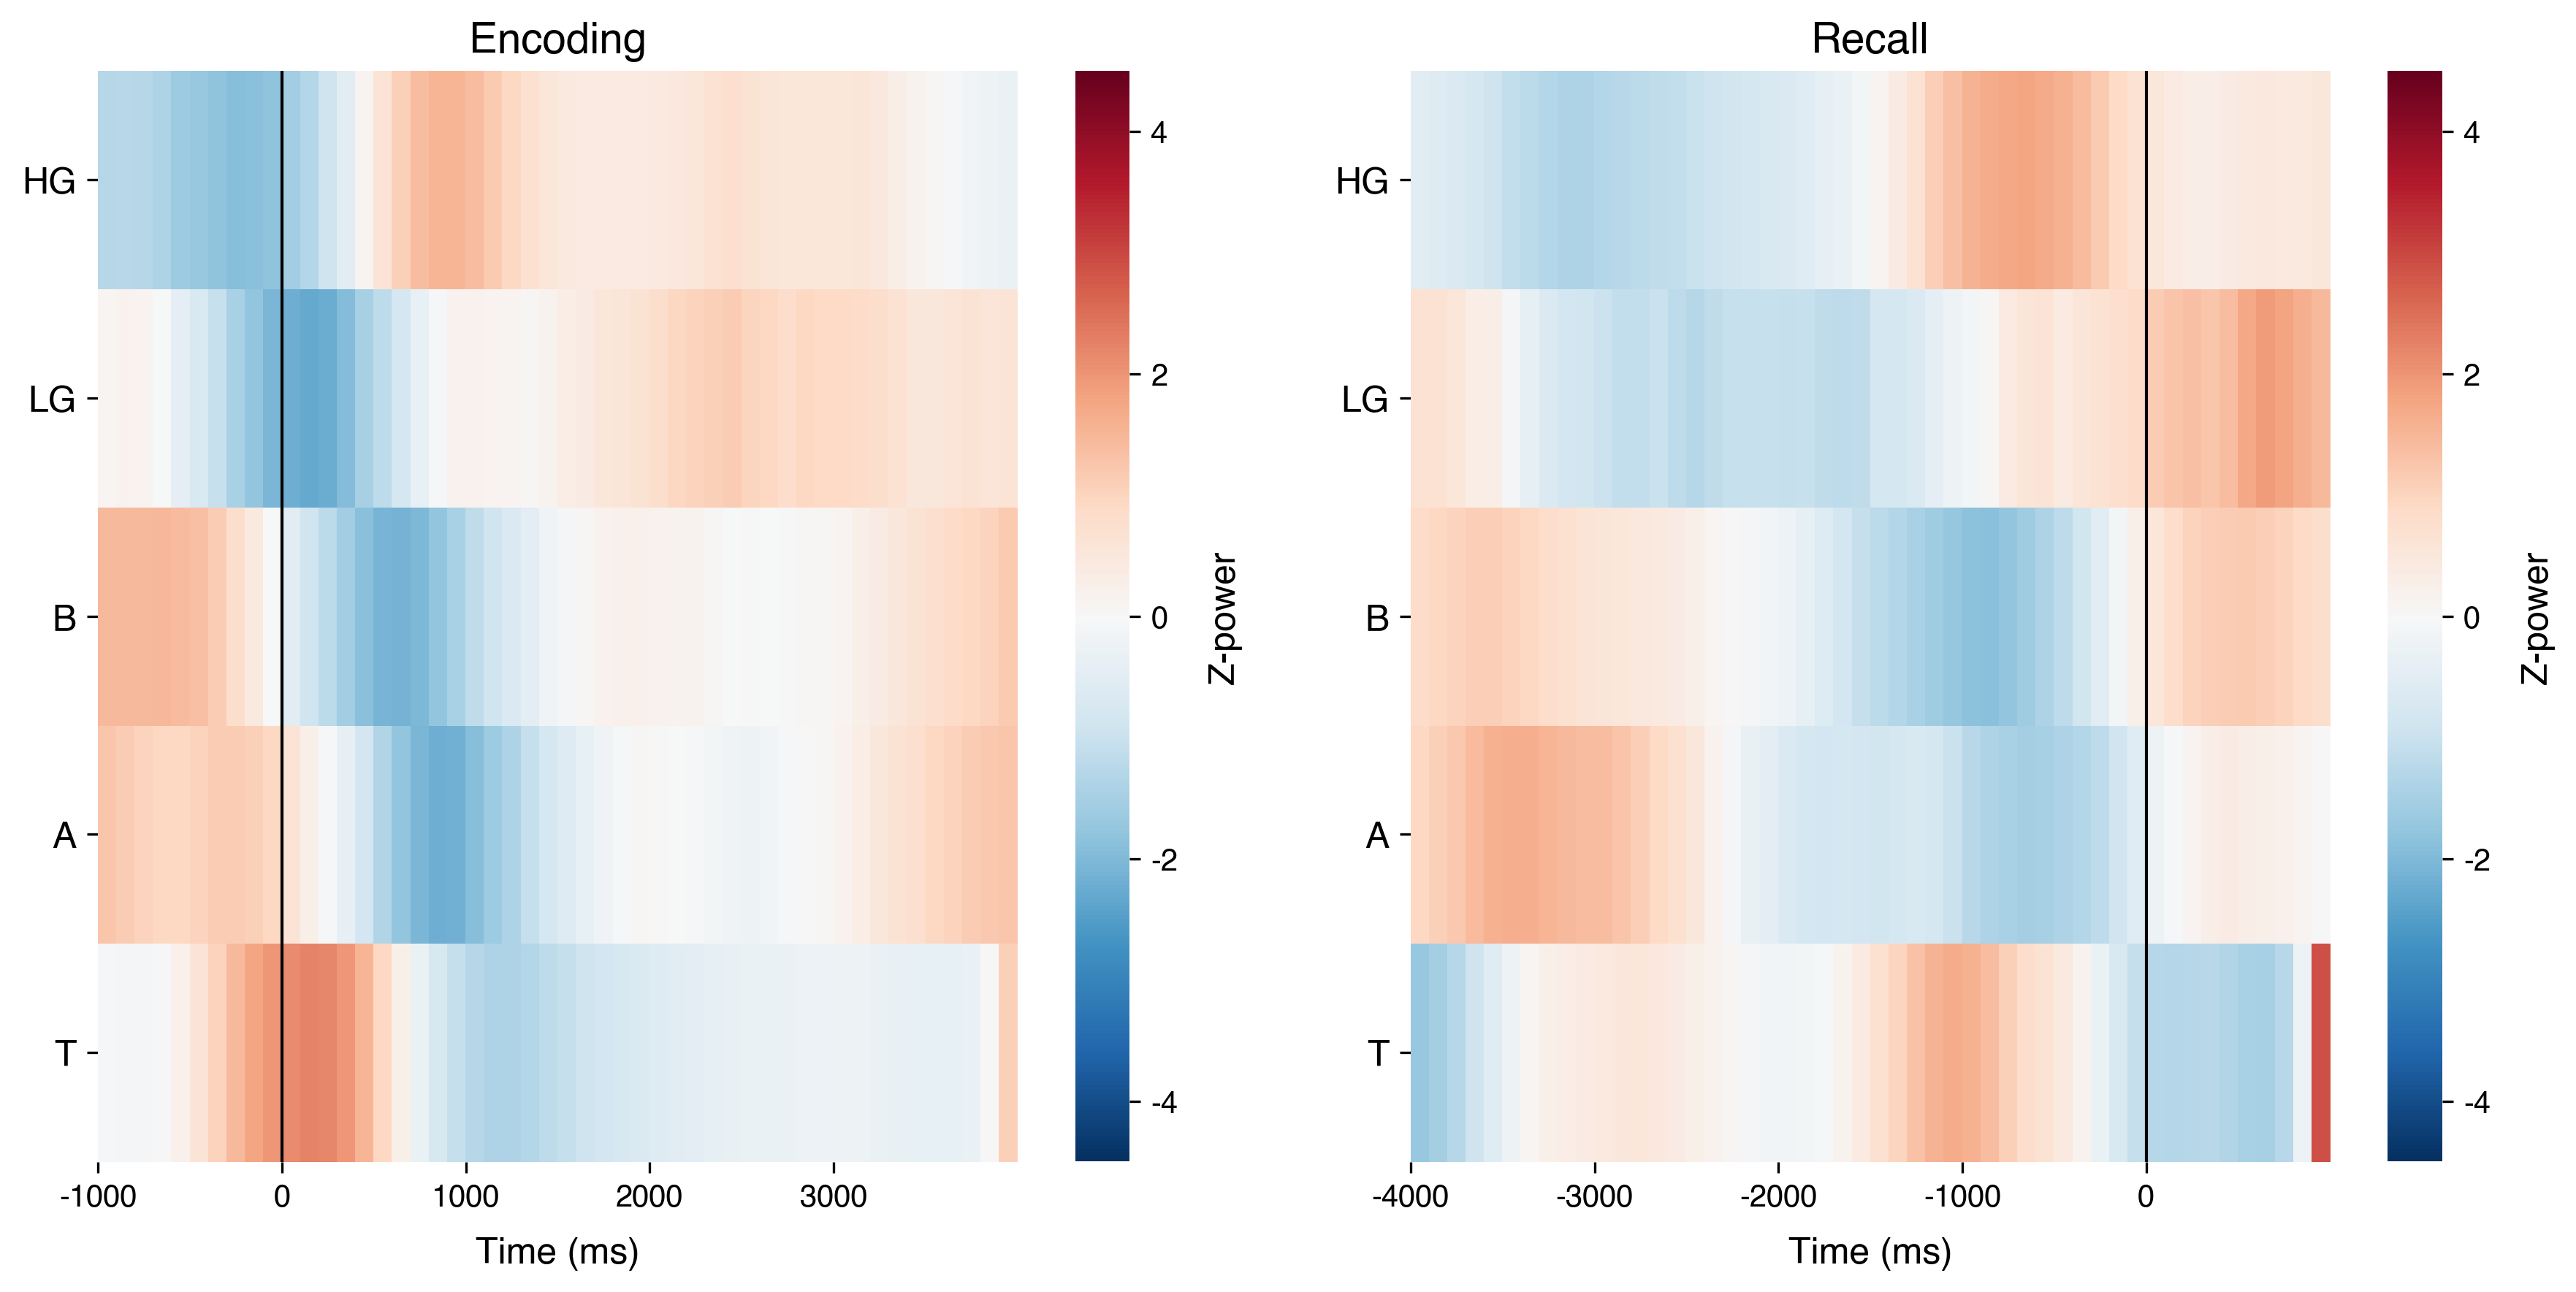

In [709]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

trial_types = ['enc', 'rec']
for i, trial_type in enumerate(trial_types):
    ax[i] = sns.heatmap(stats.zscore(np.mean(power[trial_type], axis=(0, 1)), axis=1), 
                        vmin=-4.5, vmax=4.5, cmap='RdBu_r', cbar=True, square=False, ax=ax[i])
    ax[i].axvline(x=np.where(epoch_times[trial_type]==0)[0], color='k', linewidth=1, alpha=1)
    ax[i].invert_yaxis()
    ax[i].set_xlim([0, 50])
    ax[i].set_xticks([0, 10, 20, 30, 40])
    ax[i].set_xticklabels(epoch_times[trial_type][[0, 10, 20, 30, 40]], fontsize=tickfontsize)
    ax[i].set_xlabel('Time (ms)', fontsize=labelfontsize, labelpad=8)
    ax[i].set_title('Encoding' if trial_type=='enc' else 'Recall', y=1.02, fontsize=figfontsize)
    ax[i].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
    ax[i].set_yticklabels(['T', 'A', 'B', 'LG', 'HG'], fontsize=labelfontsize, rotation=0)

    cbar = ax[i].collections[0].colorbar
    cbar.set_ticks(np.linspace(-4, 4, 5))
    cbar.set_ticklabels(np.linspace(-4, 4, 5).astype(np.int))
    cbar.ax.tick_params(labelsize=tickfontsize)
    cbar.ax.ticklabel_format()
    cbar.set_label('Z-power', fontsize=labelfontsize)

fig.tight_layout(w_pad=2)

In [710]:
# Z-score powers across trials, separately for each channel x freq x time 
# combination, and independently for encoding and retrieval events.
power['enc'] = stats.zscore(power['enc'], axis=0)
power['rec'] = stats.zscore(power['rec'], axis=0)

# Calculate encoding/retrieval power similarity

In [563]:
from sklearn.metrics.pairwise import cosine_similarity

def calc_reinstatement(enc_pow, rec_pow):
    """Return cos sim matrix for an encoding/recall pair.
    
    Parameters
    ----------
    enc_pow : np.array 
        chan x freq x time array of powers
        for a single encoding event.
    rec_pow : np.array 
        chan x freq x time array of powers
        for a single recall event.
        
    Returns
    -------
    enc_time x rec_time array of cosine similarities
    (calculated across chan-freq features)
    """
    # Reshape the arrays.
    enc_pow = np.transpose(enc_pow, (2, 0, 1))
    enc_pow = enc_pow.reshape((enc_pow.shape[0], np.prod(enc_pow.shape[1:]))) # time x chan-freq feature
    rec_pow = np.transpose(rec_pow, (2, 0, 1))
    rec_pow = rec_pow.reshape((rec_pow.shape[0], np.prod(rec_pow.shape[1:]))) # time x chan-freq feature

    # Return the cosine similarities across features between
    # each pair of encoding and retrieval times.
    return cosine_similarity(enc_pow, rec_pow)

In [711]:
# Obtain cosine similarity matrices for each encoding/recall pair.
start_time = time()

event_pairs['cos_sim'] = event_pairs.apply(lambda x: calc_reinstatement(power['enc'][x['idx_enc_pos'], :, :, :], power['rec'][x['idx_rec_pos'], :, :, :]), axis=1)

# Save event pairs.
d = '/home1/dscho/projects/theta_reinstatement/data/event_pairs'
f = os.path.join(d, '{}-event_pairs.pkl'.format(subj_sess))
dio.save_pickle(event_pairs, f)

print('Done in {:.2f} s'.format(time() - start_time))

Saved /home1/dscho/projects/theta_reinstatement/data/event_pairs/R1002P_ses0-event_pairs.pkl
Done in 0.56 s


In [682]:
# Save event pairs.
event_pairs_dir = '/home1/dscho/projects/theta_reinstatement/data/event_pairs'
f = os.path.join(event_pairs_dir, '{}-event_pairs.pkl'.format(subj_sess))
dio.save_pickle(event_pairs, f)

Saved /home1/dscho/projects/theta_reinstatement/data/event_pairs/R1042M_ses0-event_pairs.pkl


# Debug failed runs

In [58]:
reload(palr)

<module 'pal_reinstatement' from '/home1/dscho/code/projects/theta_reinstatement/pal_reinstatement.py'>

In [69]:
expmt

'PAL1'

In [75]:
# Select a single subject and session to analyze.
# Done: 10
subj = 'R1023J'
sess = 0
iList = 5
expmt = 'PAL1'

# ----------------------------
reader = CMLReader(subj, expmt, sess)
events, event_stats = palr.reader_load_events(reader, verbose=False)
lists = np.array([i for i in pd.unique(events['list']) if (i>0)])
list_ = lists[iList]
subj_sess = '{}_ses{}_list{}'.format(subj, sess, list_)
print(subj_sess, '\nn={} sessions'.format(len(pal_subjs.loc[subj]['session'])))

R1023J_ses0_list6 
n=1 sessions


In [76]:
start_time = time()

event_pairs = palr.run_sess(subj, sess, list_)

print('Done in {:.1f} secs'.format(time() - start_time))

Subj: R1023J
Sess: 0
Experiment: PAL1


n_events : 1305
n_lists : 25
n_study_pairs : 150
n_test_probes : 150
n_rec_events : 152
n_correct : 77
pct_correct : 51.3%
n_pass : 65
pct_pass : 43.3%
n_intrusions : 1
pct_intrusions : 0.7%

TEST_PROBE        150
START              26
ENCODING_START     25
REC_START         150
TEST_ORIENT       150
STUDY_PAIR        150
TEST_START         25
SESS_START          1
STOP               26
REC_END           150
MATH_START         25
REC_EVENT         152
PROB              100
MATH_END           25
STUDY_ORIENT      150
Name: type, dtype: int64

Encoding durations:
899.1 +/- 71.4ms (min=784, max=1018) between study orient and study pair onset
5025.0 +/- 0.4ms (min=5023, max=5026) duration each study pair is shown
next study orient immediately follows study pair offset



/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1023J/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1023J/tal/R1023J_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /data10/RAM/subjects/R1023J/docs/electrode_categories.txt
/scratch/pwanda/electrode_categories/electrode_categories_R1023J.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1023J/experiments/PAL1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1023J/eeg.noreref/params

Recall durations:
901.8 +/- 65.1ms (min=801, max=1036) between test orient and test probe onset
5019.9 +/- 6.9ms (min=4989, max=5039) duration each test probe is shown
21.7 +/- 5.9ms (min=17, max=41) between test orient and test probe onset

36 event pairs
R1023J PAL1 missing localization file
Keeping 75/75 bipolar pairs

Buffer is 1500 ms; 1500 samples

Without buffer:
enc: -1000 to 4000 ms
rec: -4000 to 1000 ms

With buffer:
enc: -2500 to 5500 ms
rec: -5500 to 2500 ms
enc: 50 epochs (1500, 1600, ..., 6400)
rec: 50 epochs (1500, 1600, ..., 6400)
enc:
6 trials
75 channels
8000 timepoints over 8000 ms

1000 Hz sr
Calculating power...
Making power time bins...
Saved /home1/dscho/projects/theta_reinstatement/data/morlet/power/R1023J_ses0_list6-enc-power-width6-2to100Hz-46freqs-log10--1000to4000ms-500ms_bins-100ms_spacing.pkl
rec:
6 trials
75 channels
8000 timepoints over 8000 ms

1000 Hz sr
Calculating power...
Making power time bins...
Saved /home1/dscho/projects/theta_reinstatement/data

In [56]:
## LOAD EVENTS
## -----------
events, event_stats = palr.reader_load_events(reader, verbose=False)

# Restrict events to the specified list.
if list_ != 'all':
    events = events.loc[events['list']==list_]

## LOAD EVENT PAIRS
## ----------------
event_pairs = palr.get_event_pairs(events, list_=list_, pair_type='enc-rec')

# Add columns for the relative positions of each encoding and retrieval event.
idx_enc_pos = {v:i for i, v in enumerate(event_pairs['idx_enc'].unique())}
idx_rec_pos = {v:i for i, v in enumerate(event_pairs['idx_rec'].unique())}
event_pairs.insert(4, 'idx_enc_pos', event_pairs['idx_enc'].apply(lambda x: idx_enc_pos[x]))
event_pairs.insert(6, 'idx_rec_pos', event_pairs['idx_rec'].apply(lambda x: idx_rec_pos[x]))

In [57]:
event_pairs

,subject,session,list,idx_enc,idx_enc_pos,idx_rec,idx_rec_pos,pair_type,eegoffset_enc,eegoffset_rec,serialpos_enc,serialpos_rec,serialpos_lag,probepos_enc,probepos_rec,probepos_lag,correct_enc,correct_rec,intrusion_rec,resp_pass
0,R1023J,0,1,8,0,31,0,enc-rec,457063,519503,1,3,-2,5,1,4,0,1,0,0
1,R1023J,0,1,8,0,36,1,enc-rec,457063,528429,1,6,-5,5,2,3,0,0,0,0
2,R1023J,0,1,8,0,41,2,enc-rec,457063,530656,1,5,-4,5,3,2,0,1,0,0
3,R1023J,0,1,8,0,46,3,enc-rec,457063,536364,1,4,-3,5,4,1,0,1,0,0
4,R1023J,0,1,8,0,52,4,enc-rec,457063,546179,1,1,0,5,5,0,0,0,0,0
5,R1023J,0,1,8,0,56,5,enc-rec,457063,548365,1,2,-1,5,6,-1,0,1,0,0
6,R1023J,0,1,10,1,31,0,enc-rec,462940,519503,2,3,-1,6,1,5,1,1,0,0
7,R1023J,0,1,10,1,36,1,enc-rec,462940,528429,2,6,-4,6,2,4,1,0,0,0
8,R1023J,0,1,10,1,41,2,enc-rec,462940,530656,2,5,-3,6,3,3,1,1,0,0
9,R1023J,0,1,10,1,46,3,enc-rec,462940,536364,2,4,-2,6,4,2,1,1,0,0


In [47]:
dat = dio.open_pickle('/home1/dscho/projects/theta_reinstatement/data/morlet/power/R1023J_ses0_list1-enc-power-width6-2to100Hz-46freqs-log10--1000to4000ms-500ms_bins-100ms_spacing.pkl')
dat.shape

(6, 75, 5, 50)

In [45]:
dat = dio.open_pickle('/home1/dscho/projects/theta_reinstatement/data/morlet/power/R1023J_ses0_list1-rec-power-width6-2to100Hz-46freqs-log10--4000to1000ms-500ms_bins-100ms_spacing.pkl')
dat.shape

(6, 75, 5, 50)

# Visualize power reinstatement

In [142]:
df.columns

Index(['idx_enc', 'idx_enc_pos', 'idx_rec', 'idx_rec_pos', 'eegoffset_enc',
       'eegoffset_rec', 'list', 'serialpos_enc', 'serialpos_rec', 'lag',
       'correct_enc', 'correct_rec', 'intrusion_rec', 'resp_pass', 'cos_sim'],
      dtype='object')

In [162]:
len(aop.unique(event_pairs['subj']))

14

In [89]:
# Load files.
event_pairs_dir = '/home1/dscho/projects/theta_reinstatement/data/event_pairs'
files = glob(os.path.join(event_pairs_dir, '*.pkl'))
print('{} files'.format(len(files)))
event_pairs = pd.DataFrame([])
for f in files:
#     subj, sess, list_ = os.path.basename(f).split('-')[0].split('_')
#     sess = int(sess[3:])
    df = dio.open_pickle(f)
#     df.insert(0, 'subj', subj)
#     df.insert(1, 'sess', sess)
    event_pairs = pd.concat((event_pairs, df))
print('{} subjects, {} sessions, and {} event pairs'
      .format(len(np.unique(event_pairs['subject'])), len(event_pairs.groupby(['subject', 'session']).size()), len(event_pairs)))

1863 files
39 subjects, 78 sessions, and 73266 event pairs


In [124]:
event_pairs = event_pairs.query("(subject!=['R1212P'])")

In [126]:
# Group cos sim matrices by enc/rec category.
sims = od([])
sims['corr'] = np.array(event_pairs.query("(serialpos_lag==0) & (correct_rec==1)")['cos_sim'].tolist())
sims['intru'] = np.array(event_pairs.query("(serialpos_lag==0) & (intrusion_rec!=0)")['cos_sim'].tolist())
sims['pass'] = np.array(event_pairs.query("(serialpos_lag==0) & (resp_pass==1)")['cos_sim'].tolist())
sims['incorr'] = np.array(event_pairs.query("(serialpos_lag==0) & (correct_rec==0)")['cos_sim'].tolist())
sims['shuf_corr_adj'] = np.array(event_pairs.query("(serialpos_lag==1) & ((correct_enc==1) | (correct_rec==1))")['cos_sim'].tolist())
sims['shuf_corr_all'] = np.array(event_pairs.query("(serialpos_lag!=0) & ((correct_enc==1) | (correct_rec==1))")['cos_sim'].tolist())
sims['shuf_all'] = np.array(event_pairs.query("(serialpos_lag!=0)")['cos_sim'].tolist())

for k, v in sims.items():
    print('{} : {}'.format(k, len(v)))

corr : 5854
intru : 597
pass : 727
incorr : 5810
shuf_corr_adj : 6754
shuf_corr_all : 41187
shuf_all : 58320


In [127]:
vmax = 0
for i, k in enumerate(sims.keys()):
    arr = np.mean(sims[k], axis=0)
    vmax = np.max((vmax, np.abs(arr).max()))
    print('{}: {:.3f}; {:.3f}'.format(k, np.abs(arr).max(), vmax))

corr: 0.012; 0.012
intru: 0.022; 0.022
pass: 0.017; 0.022
incorr: 0.009; 0.022
shuf_corr_adj: 0.007; 0.022
shuf_corr_all: 0.003; 0.022
shuf_all: 0.002; 0.022


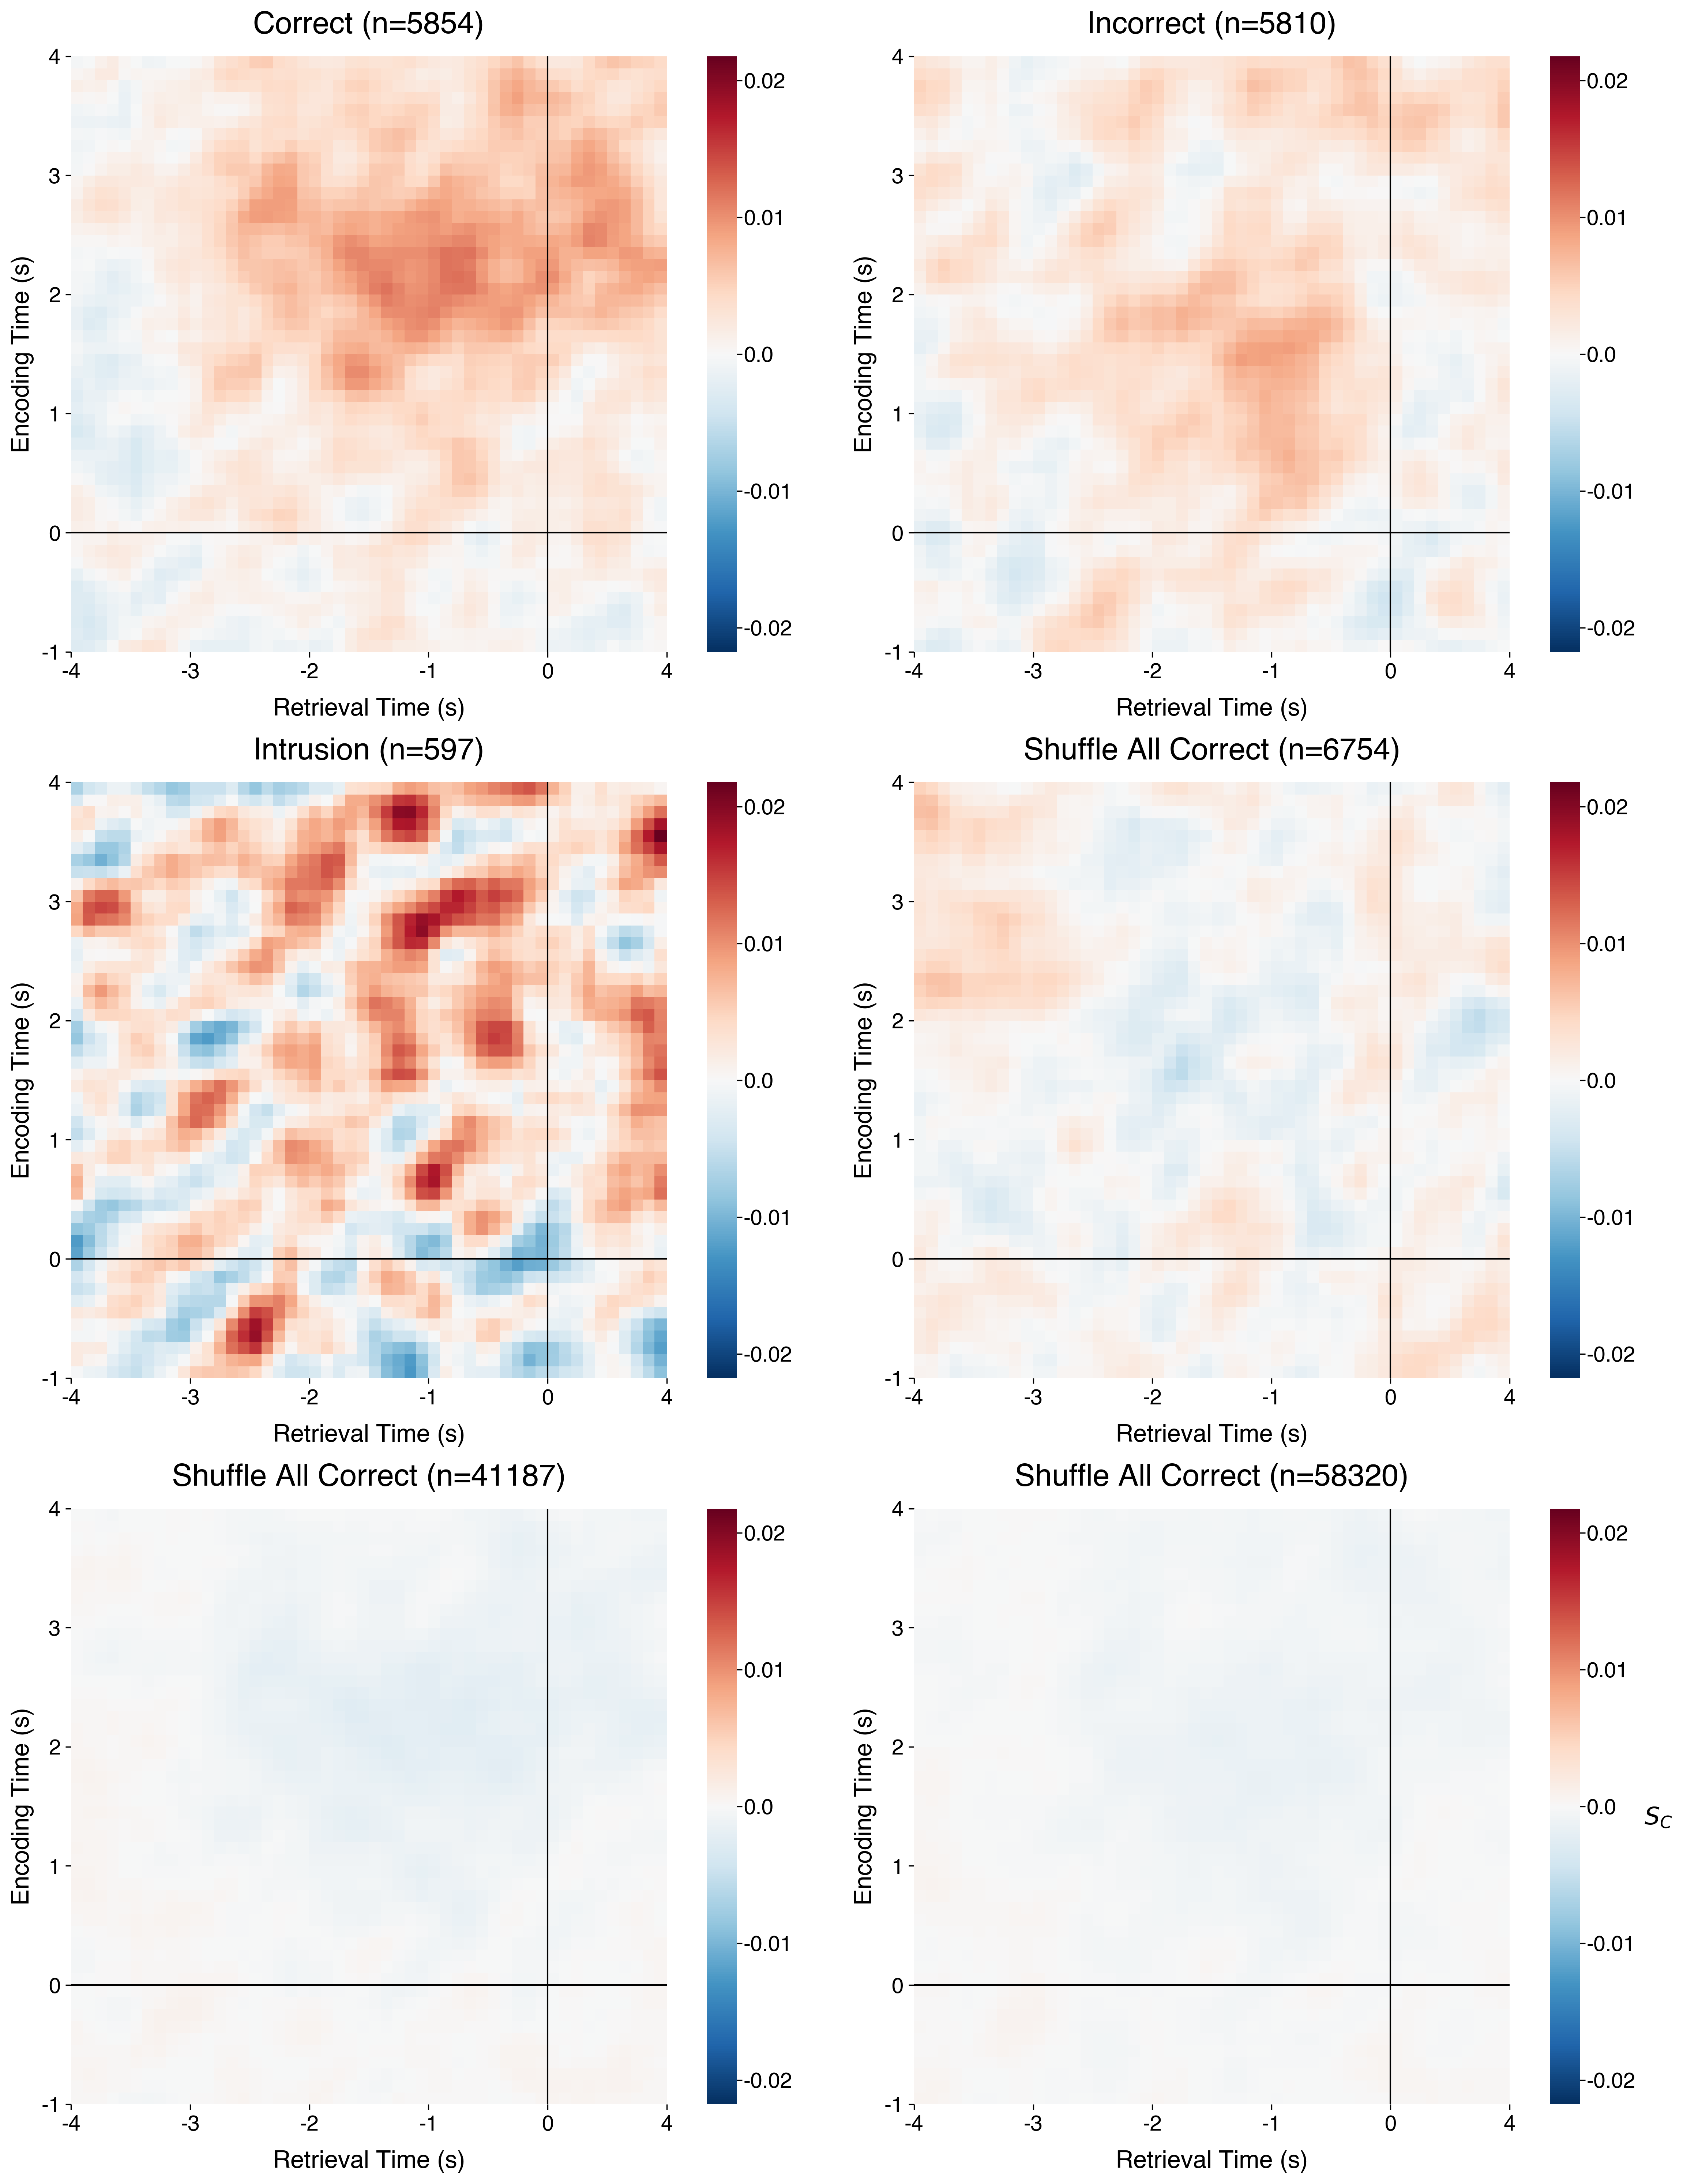

In [133]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16
figfontsize = 20
titles = {'corr': 'Correct (n={})', 
          'incorr': 'Incorrect (n={})', 
          'intru': 'Intrusion (n={})', 
          'shuf_corr_adj': 'Shuffle All Correct (n={})',
          'shuf_corr_all': 'Shuffle All Correct (n={})',
          'shuf_all': 'Shuffle All Correct (n={})'}

vmax = 0
for i, k in enumerate(['corr', 'incorr', 'intru', 'shuf_corr_adj', 'shuf_corr_all', 'shuf_all']):
    arr = np.mean(sims[k], axis=0).T
    vmax = np.max((vmax, np.abs(arr).max()))
vmin = -vmax
# vmin = 0

for i, k in enumerate(['corr', 'incorr', 'intru', 'shuf_corr_adj', 'shuf_corr_all', 'shuf_all']):
    n = sims[k].shape[0]
    arr = np.mean(sims[k], axis=0).T
#     vmax = np.round(np.max(np.abs(arr)), 1)
#     vmin = -vmax
    ax[i] = sns.heatmap(arr, vmin=vmin, vmax=vmax, cmap='RdBu_r', cbar=True, square=True, ax=ax[i])
#     ax[i] = sns.heatmap(arr, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=True, ax=ax[i])
    ax[i].axvline(x=np.where(epoch_times['rec']==0)[0], color='k', linewidth=1, alpha=1)
    ax[i].axhline(y=np.where(epoch_times['enc']==0)[0], color='k', linewidth=1, alpha=1)
    ax[i].invert_yaxis()
    ax[i].set_xlim([0, 50])
    ax[i].set_xticks([0, 10, 20, 30, 40, 50])
    ax[i].set_xticklabels((1e-3 * np.append(epoch_times['rec'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                          fontsize=tickfontsize)
    ax[i].set_xlabel('Retrieval Time (s)', fontsize=labelfontsize, labelpad=10)
    ax[i].set_ylim([0, 50])
    ax[i].set_yticks([0, 10, 20, 30, 40, 50])
    ax[i].set_yticklabels((1e-3 * np.append(epoch_times['enc'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                          fontsize=tickfontsize, rotation=0)
    ax[i].set_ylabel('Encoding Time (s)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(titles[k].format(n), pad=15, fontsize=figfontsize)
    
    cbar = ax[i].collections[0].colorbar
    if vmax > 1:
        cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5))
        cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2]
                             for x in np.linspace(int(vmin), int(vmax), 5)])
    else:
        cbar.set_ticks(np.linspace(np.round(vmin, 2), np.round(vmax, 2), 5))
        cbar.set_ticklabels([str(np.round(x, 2)) if str(np.round(x, 2)).find(".0") == -1 else str(np.round(x, 2))
                             for x in np.linspace(np.round(vmin, 2), np.round(vmax, 2), 5)])
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    if i == len(ax)-1:
        cbar.set_label('$S_C$', fontsize=labelfontsize, rotation=0, labelpad=15)

fig.tight_layout(w_pad=0)

In [136]:
sims[k].shape

(38, 50, 50)

In [134]:
# Group cos sim matrices by enc/rec category, separetly for each subject.
sims = od([])

qrys = od([("corr", "(serialpos_lag==0) & (correct_rec==1)"),
           ("intru", "(serialpos_lag==0) & (intrusion_rec!=0)"),
           ("pass", "(serialpos_lag==0) & (resp_pass==1)"),
           ("incorr", "(serialpos_lag==0) & (correct_rec==0)"),
           ("shuf_corr_adj", "(serialpos_lag==1) & ((correct_enc==1) | (correct_rec==1))"),
           ("shuf_corr_all", "(serialpos_lag!=0) & ((correct_enc==1) | (correct_rec==1))"),
           ("shuf_incorr_adj", "(serialpos_lag==1) & ((correct_enc==0) | (correct_rec==0))"),
           ("shuf_incorr_all", "(serialpos_lag!=0) & ((correct_enc==0) | (correct_rec==0))"),
           ("shuf_all", "(serialpos_lag!=0)")])

for k, qry in qrys.items():
    sims[k] = np.array(event_pairs.query(qry).query("(subject!=['R1212P'])").groupby('subject')['cos_sim'].apply(lambda x: np.mean(x, axis=0)).tolist())

titles = {'corr': 'Correct (n={})', 
          'intru': 'Intrusion (n={})',
          'pass': 'Pass  (n={})',
          'incorr': 'Incorrect (n={})', 
          'shuf_corr_adj': 'Shuffle Adj Correct (n={})', 
          'shuf_corr_all': 'Shuffle All Correct (n={})',
          'shuf_incorr_adj': 'Shuffle Adj Incorrect (n={})', 
          'shuf_incorr_all': 'Shuffle All Incorrect (n={})',
          'shuf_all': 'Shuffle All (n={})'}

for k, v in sims.items():
    print('{} : {}'.format(k, len(v)))

corr : 38
intru : 37
pass : 10
incorr : 38
shuf_corr_adj : 38
shuf_corr_all : 38
shuf_incorr_adj : 38
shuf_incorr_all : 38
shuf_all : 38


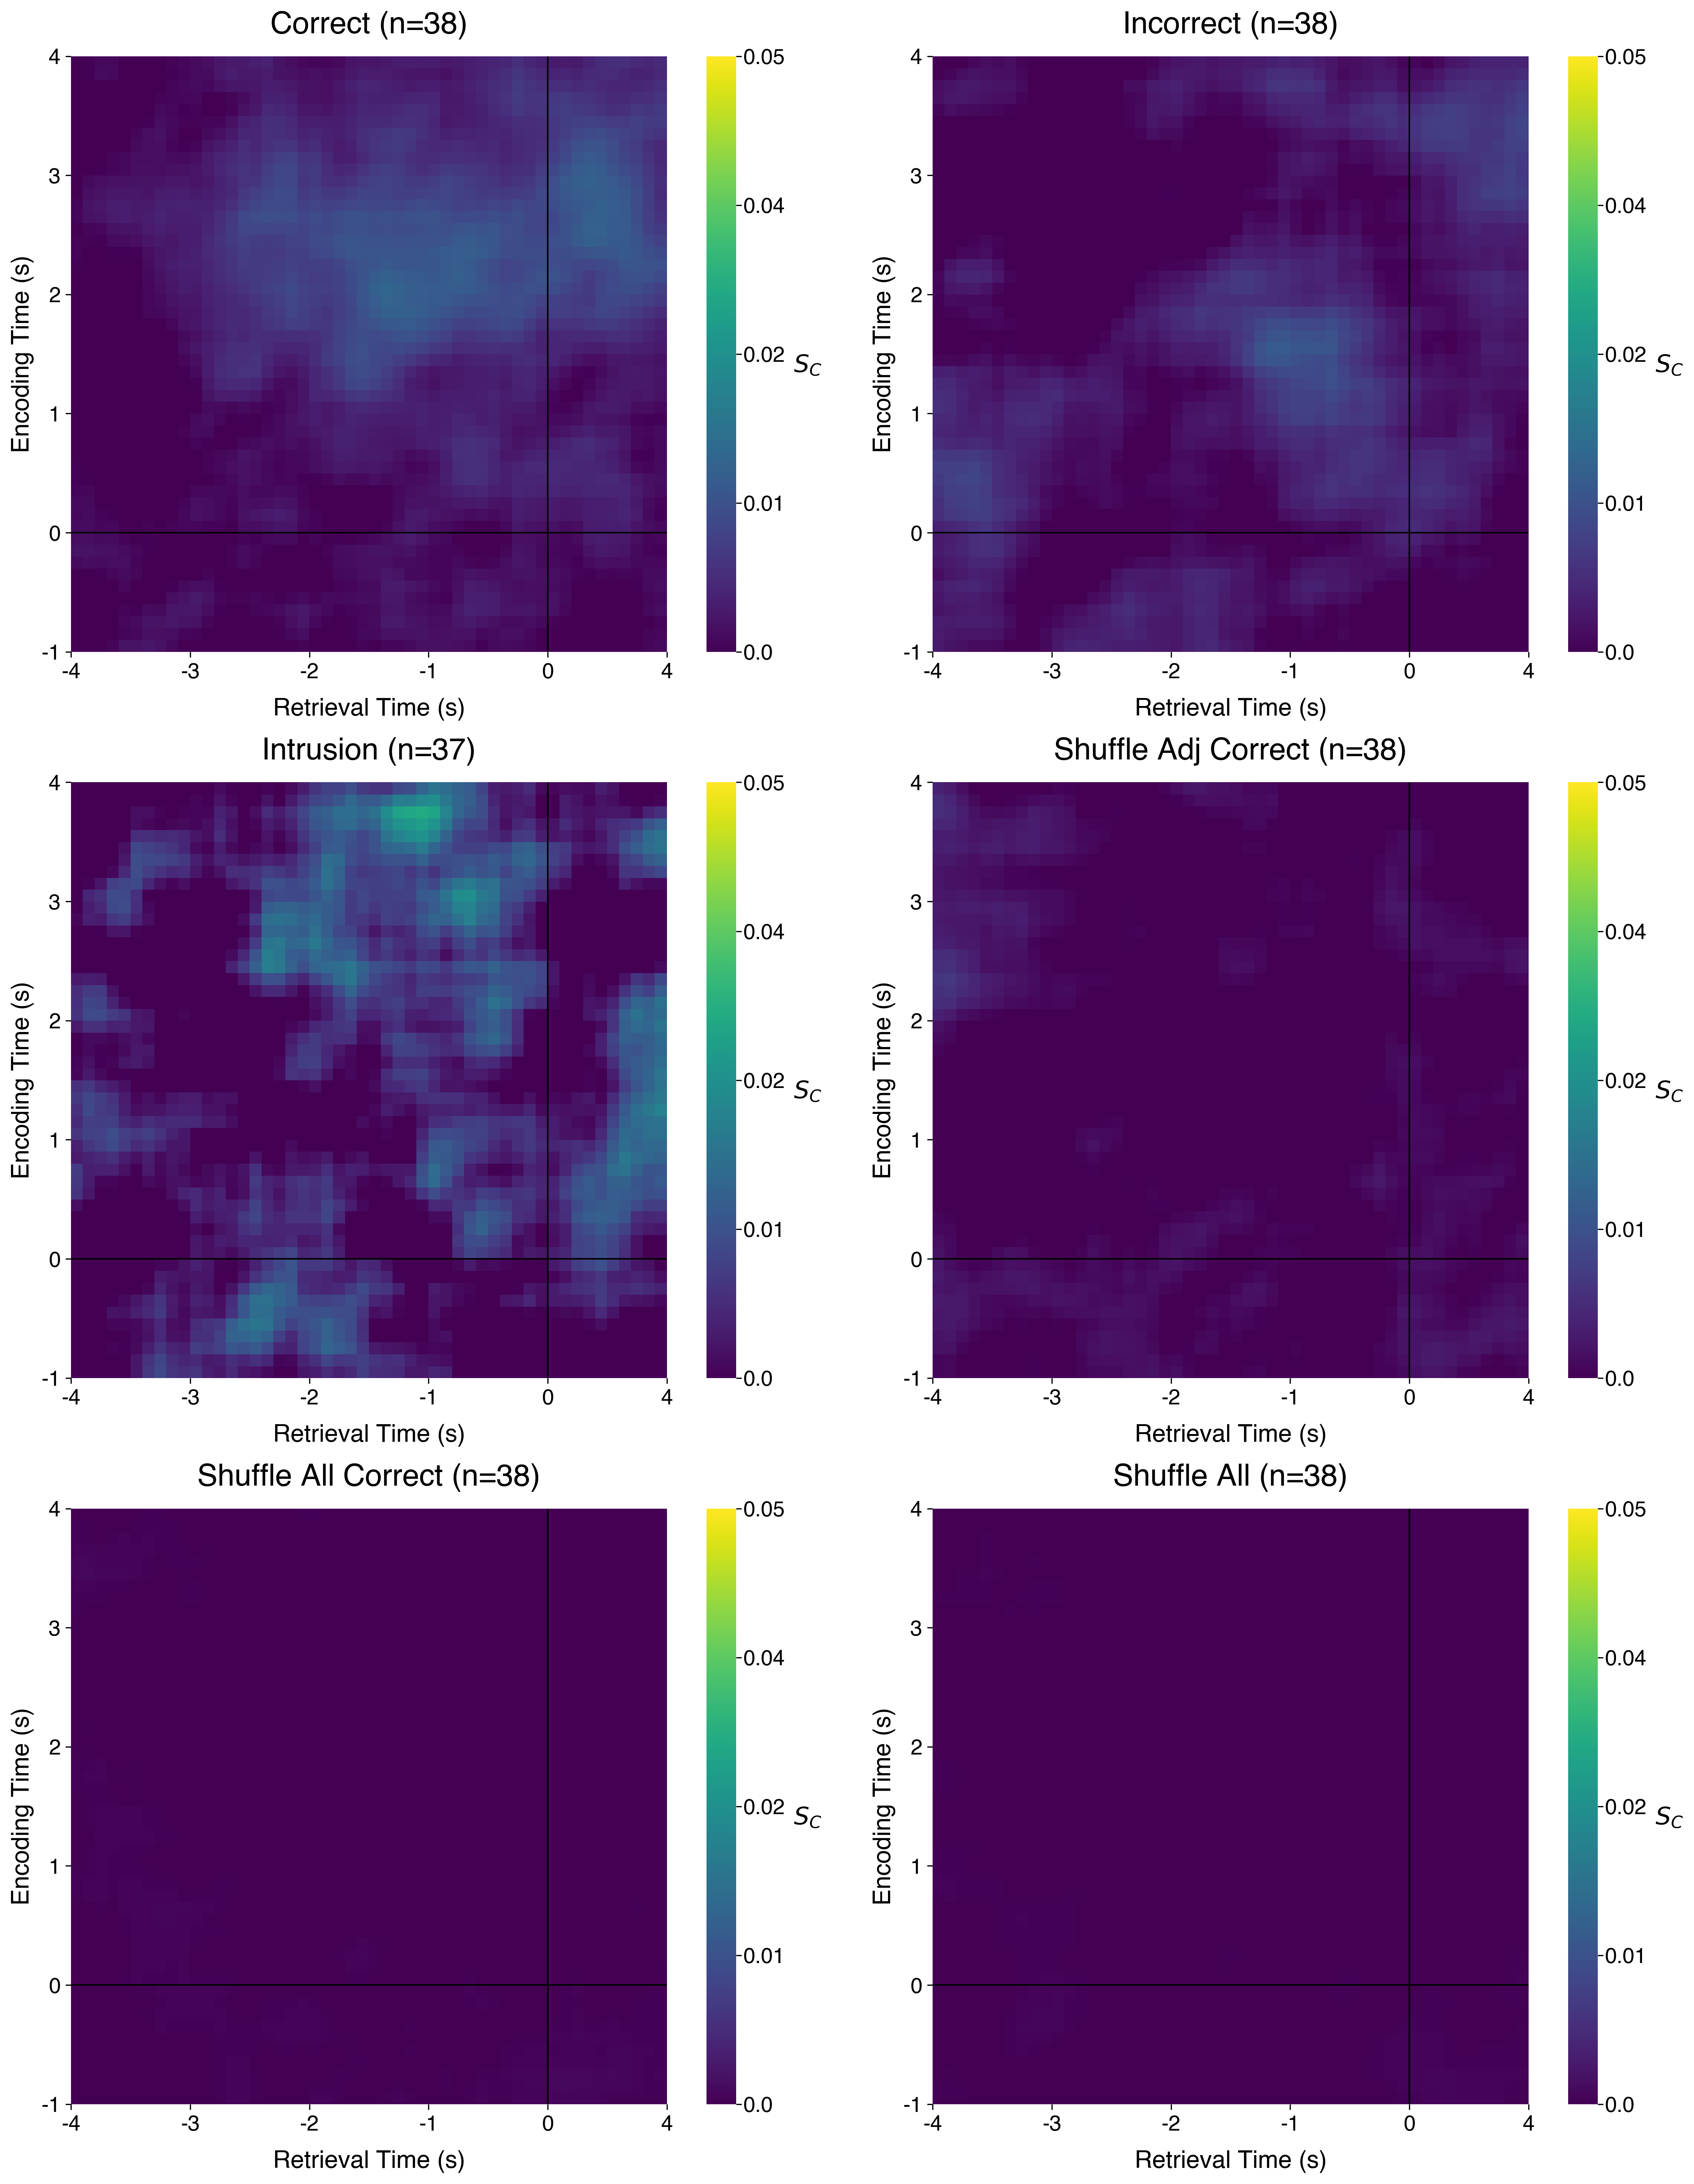

In [117]:
fig, ax = plt.subplots(3, 2, figsize=(16, 20), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16
figfontsize = 20

keys = ['corr', 'incorr', 'intru', 'shuf_corr_adj', 'shuf_corr_all', 'shuf_all']

# vmax = 0
# for i, k in enumerate(keys):
#     arr = np.median(sims[k], axis=0).T
#     vmax = np.max((vmax, np.abs(arr).max()))
vmax = 0.05
vmin = 0

for i, k in enumerate(keys):
    n = sims[k].shape[0]
    arr = np.mean(sims[k], axis=0).T
    ax[i] = sns.heatmap(arr, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=True, ax=ax[i])
    ax[i].axvline(x=np.where(epoch_times['rec']==0)[0], color='k', linewidth=1, alpha=1)
    ax[i].axhline(y=np.where(epoch_times['enc']==0)[0], color='k', linewidth=1, alpha=1)
    ax[i].invert_yaxis()
    ax[i].set_xlim([0, 50])
    ax[i].set_xticks([0, 10, 20, 30, 40, 50])
    ax[i].set_xticklabels((1e-3 * np.append(epoch_times['rec'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                          fontsize=tickfontsize)
    ax[i].set_xlabel('Retrieval Time (s)', fontsize=labelfontsize, labelpad=10)
    ax[i].set_ylim([0, 50])
    ax[i].set_yticks([0, 10, 20, 30, 40, 50])
    ax[i].set_yticklabels((1e-3 * np.append(epoch_times['enc'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                          fontsize=tickfontsize, rotation=0)
    ax[i].set_ylabel('Encoding Time (s)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(titles[k].format(n), pad=15, fontsize=figfontsize)
    
    cbar = ax[i].collections[0].colorbar
    if vmax > 1:
        cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5))
        cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2]
                             for x in np.linspace(int(vmin), int(vmax), 5)])
    else:
        cbar.set_ticks(np.linspace(np.round(vmin, 2), np.round(vmax, 2), 5))
        cbar.set_ticklabels([str(np.round(x, 2)) if str(np.round(x, 2)).find(".0") == -1 else str(np.round(x, 2))
                             for x in np.linspace(np.round(vmin, 2), np.round(vmax, 2), 5)])
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    cbar.set_label('$S_C$', fontsize=labelfontsize, rotation=0, labelpad=15)

fig.tight_layout(w_pad=0)

In [99]:
obs_qry = qrys['corr']
null_qry = qrys['shuf_corr_all']
obs = {k: np.array(v) for k, v in event_pairs.query(obs_qry).groupby('subject')['cos_sim'].apply(lambda x: list(x)).to_dict().items()}
null = {k: np.array(v) for k, v in event_pairs.query(null_qry).groupby('subject')['cos_sim'].apply(lambda x: list(x)).to_dict().items()}

In [498]:
np.min(zvals), np.max(zvals)

(-0.2670541, 0.21030435)

In [105]:
print('{} subjects'.format(len(subjs_)))
for subj in subjs_:
    print(subj, z_obs[subj].shape, z_null[subj].shape)

38 subjects
R1002P (153, 50, 50) (1116, 50, 50)
R1016M (92, 50, 50) (613, 50, 50)
R1023J (75, 50, 50) (544, 50, 50)
R1028M (25, 50, 50) (219, 50, 50)
R1031M (41, 50, 50) (348, 50, 50)
R1042M (2, 50, 50) (20, 50, 50)
R1050M (58, 50, 50) (465, 50, 50)
R1056M (35, 50, 50) (290, 50, 50)
R1060M (127, 50, 50) (735, 50, 50)
R1065J (109, 50, 50) (910, 50, 50)
R1069M (70, 50, 50) (550, 50, 50)
R1082N (266, 50, 50) (1556, 50, 50)
R1090C (134, 50, 50) (851, 50, 50)
R1091N (145, 50, 50) (856, 50, 50)
R1095N (77, 50, 50) (671, 50, 50)
R1097N (122, 50, 50) (764, 50, 50)
R1109N (120, 50, 50) (969, 50, 50)
R1111M (68, 50, 50) (523, 50, 50)
R1118N (91, 50, 50) (648, 50, 50)
R1130M (72, 50, 50) (437, 50, 50)
R1131M (36, 50, 50) (284, 50, 50)
R1136N (114, 50, 50) (714, 50, 50)
R1141T (119, 50, 50) (717, 50, 50)
R1162N (287, 50, 50) (1921, 50, 50)
R1175N (243, 50, 50) (1333, 50, 50)
R1185N (233, 50, 50) (1606, 50, 50)
R1196N (199, 50, 50) (1562, 50, 50)
R1207J (149, 50, 50) (837, 50, 50)
R1232N (175, 50, 

In [103]:
wins, wins_full, buff_ms, buff_samp = palr.get_trial_wins()
epoch_inds, epoch_times = palr.get_epoch_inds(wins, wins_full, 500, buff_samp)

Buffer is 1500 ms; 750 samples

Without buffer:
enc: -1000 to 4001 ms
rec: -4000 to 1001 ms

With buffer:
enc: -2500 to 5501 ms
rec: -5500 to 2501 ms
enc: 50 epochs (750, 800, ..., 3200)
rec: 50 epochs (750, 800, ..., 3200)


In [106]:
qrys

OrderedDict([('corr', '(serialpos_lag==0) & (correct_rec==1)'),
             ('intru', '(serialpos_lag==0) & (intrusion_rec!=0)'),
             ('pass', '(serialpos_lag==0) & (resp_pass==1)'),
             ('incorr', '(serialpos_lag==0) & (correct_rec==0)'),
             ('shuf_corr_adj',
              '(serialpos_lag==1) & ((correct_enc==1) | (correct_rec==1))'),
             ('shuf_corr_all',
              '(serialpos_lag!=0) & ((correct_enc==1) | (correct_rec==1))'),
             ('shuf_incorr_adj',
              '(serialpos_lag==1) & ((correct_enc==0) | (correct_rec==0))'),
             ('shuf_incorr_all',
              '(serialpos_lag!=0) & ((correct_enc==0) | (correct_rec==0))'),
             ('shuf_all', '(serialpos_lag!=0)')])

corr -0.031446572 0.17502415
incorr -0.07664745 0.1244975
corr_v_incorr -91.21067 8.040236
shuf_corr_adj -0.04520698 0.062389284


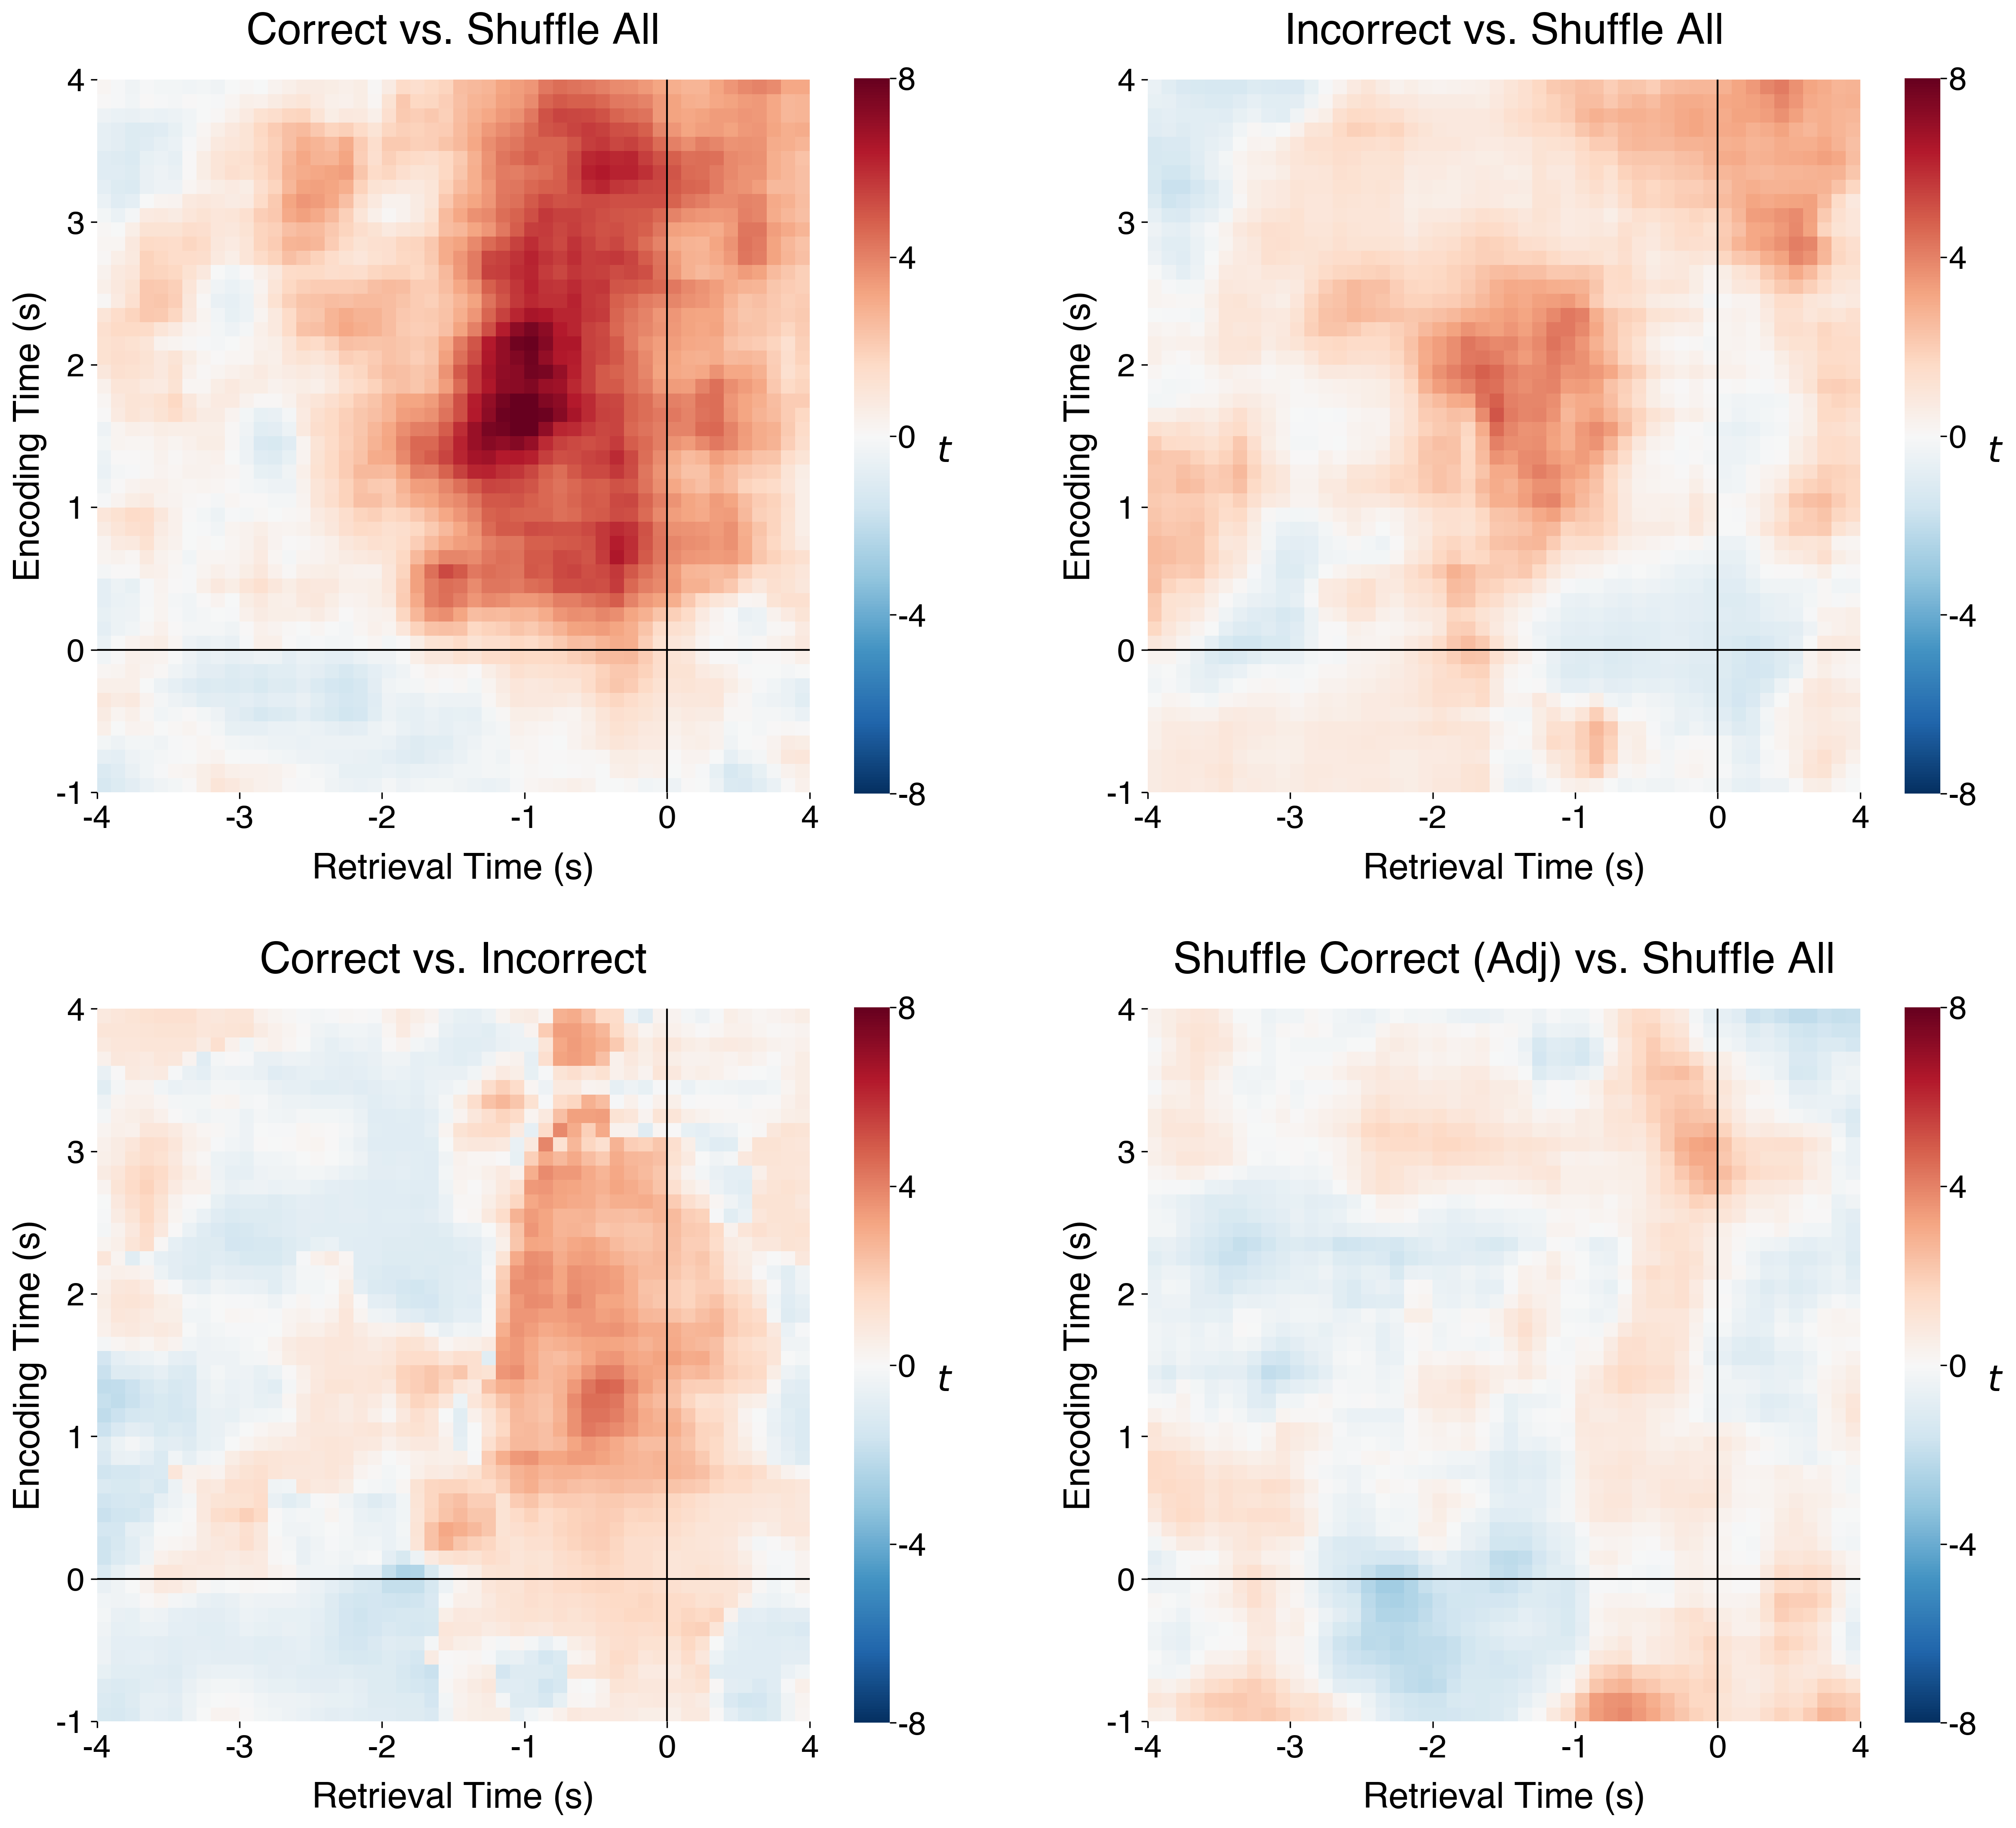

In [145]:
fig, ax = plt.subplots(2, 2, figsize=(16, 14), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14+4
labelfontsize = 16+4
figfontsize = 20+4

vmin = od([('z', 0),
           ('t', -8)])
vmax = od([('z', 0.2),
           ('t', 8)])

tests = od([('corr', (qrys['corr'], qrys['shuf_all'])),
            ('incorr', (qrys['incorr'], qrys['shuf_all'])),
            ('corr_v_incorr', (qrys['corr'], qrys['incorr'])),
            ('shuf_corr_adj', (qrys['shuf_corr_adj'], qrys['shuf_corr_all']))])

titles = od([('corr', 'Correct vs. Shuffle All'),
             ('incorr', 'Incorrect vs. Shuffle All'),
             ('corr_v_incorr', 'Correct vs. Incorrect'),
             ('shuf_corr_adj', 'Shuffle Correct (Adj) vs. Shuffle All')])

for ii, k in enumerate(tests.keys()):
    obs_qry = tests[k][0]
    null_qry = tests[k][1]
    obs = {k: np.array(v) for k, v in event_pairs.query(obs_qry).groupby('subject')['cos_sim'].apply(lambda x: list(x)).to_dict().items()}
    null = {k: np.array(v) for k, v in event_pairs.query(null_qry).groupby('subject')['cos_sim'].apply(lambda x: list(x)).to_dict().items()}
    tvals = od([])
    subjs_ = [k for k in obs if k in null]
    
    # Z-transform similarity scores across trials against means and stdevs from the null distribution.
    z_obs = od([])
    z_null = od([])
    for subj in subjs_:
        mean_ = np.expand_dims(np.mean(null[subj], axis=0), axis=0)
        std_ = np.expand_dims(np.std(null[subj], axis=0), axis=0)
        z_obs[subj] = (obs[subj] - mean_) / std_
        z_null[subj] = (null[subj] - mean_) / std_
        
    # Perform a paired t-test, across subjects, between mean obs Z-score and mean null Z-score,
    # averaging across trials within each subject, and run separately at each enc~rec timepoint.
    tvals, pvals = stats.ttest_rel(np.array([np.mean(z_obs[subj], axis=0) for subj in subjs_]), 
                                   np.array([np.mean(z_null[subj], axis=0) for subj in subjs_]), 
                                   axis=0)
    zvals = np.mean([np.mean(z_obs[subj], axis=0) for subj in subjs_], axis=0)
    print(k, np.min(zvals), np.max(zvals))
    
    ax[ii] = sns.heatmap(tvals, vmin=vmin['t'], vmax=vmax['t'], cmap='RdBu_r', cbar=True, square=True, ax=ax[ii])
    ax[ii].axvline(x=np.where(epoch_times['rec']==0)[0], color='k', linewidth=1, alpha=1)
    ax[ii].axhline(y=np.where(epoch_times['enc']==0)[0], color='k', linewidth=1, alpha=1)
    ax[ii].invert_yaxis()
    ax[ii].set_xlim([0, 50])
    ax[ii].set_xticks([0, 10, 20, 30, 40, 50])
    ax[ii].set_xticklabels((1e-3 * np.append(epoch_times['rec'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                          fontsize=tickfontsize)
    ax[ii].set_xlabel('Retrieval Time (s)', fontsize=labelfontsize, labelpad=10)
    ax[ii].set_ylim([0, 50])
    ax[ii].set_yticks([0, 10, 20, 30, 40, 50])
    ax[ii].set_yticklabels((1e-3 * np.append(epoch_times['enc'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                          fontsize=tickfontsize, rotation=0)
    ax[ii].set_ylabel('Encoding Time (s)', fontsize=labelfontsize, labelpad=5)
    ax[ii].set_title(titles[k].format(len(subjs_)), pad=20, fontsize=figfontsize)

    cbar = ax[ii].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    cbar.set_label('$t$', fontsize=labelfontsize, rotation=0, labelpad=10)
    if vmax['t'] > 1:
        cbar.set_ticks(np.linspace(int(vmin['t']), int(vmax['t']), 5))
        cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2]
                             for x in np.linspace(int(vmin['t']), int(vmax['t']), 5)])
    else:
        cbar.set_ticks(np.linspace(np.round(vmin['t'], 2), np.round(vmax['t'], 2), 5))
        cbar.set_ticklabels([str(np.round(x, 2)) if str(np.round(x, 2)).find(".0") == -1 else str(np.round(x, 2))
                             for x in np.linspace(np.round(vmin['t'], 2), np.round(vmax['t'], 2), 5)])

fig.tight_layout(h_pad=5, w_pad=5)

-0.031446572 0.17502415
-0.07664745 0.1244975
-0.14942054 0.2373657
-0.04520698 0.062389284


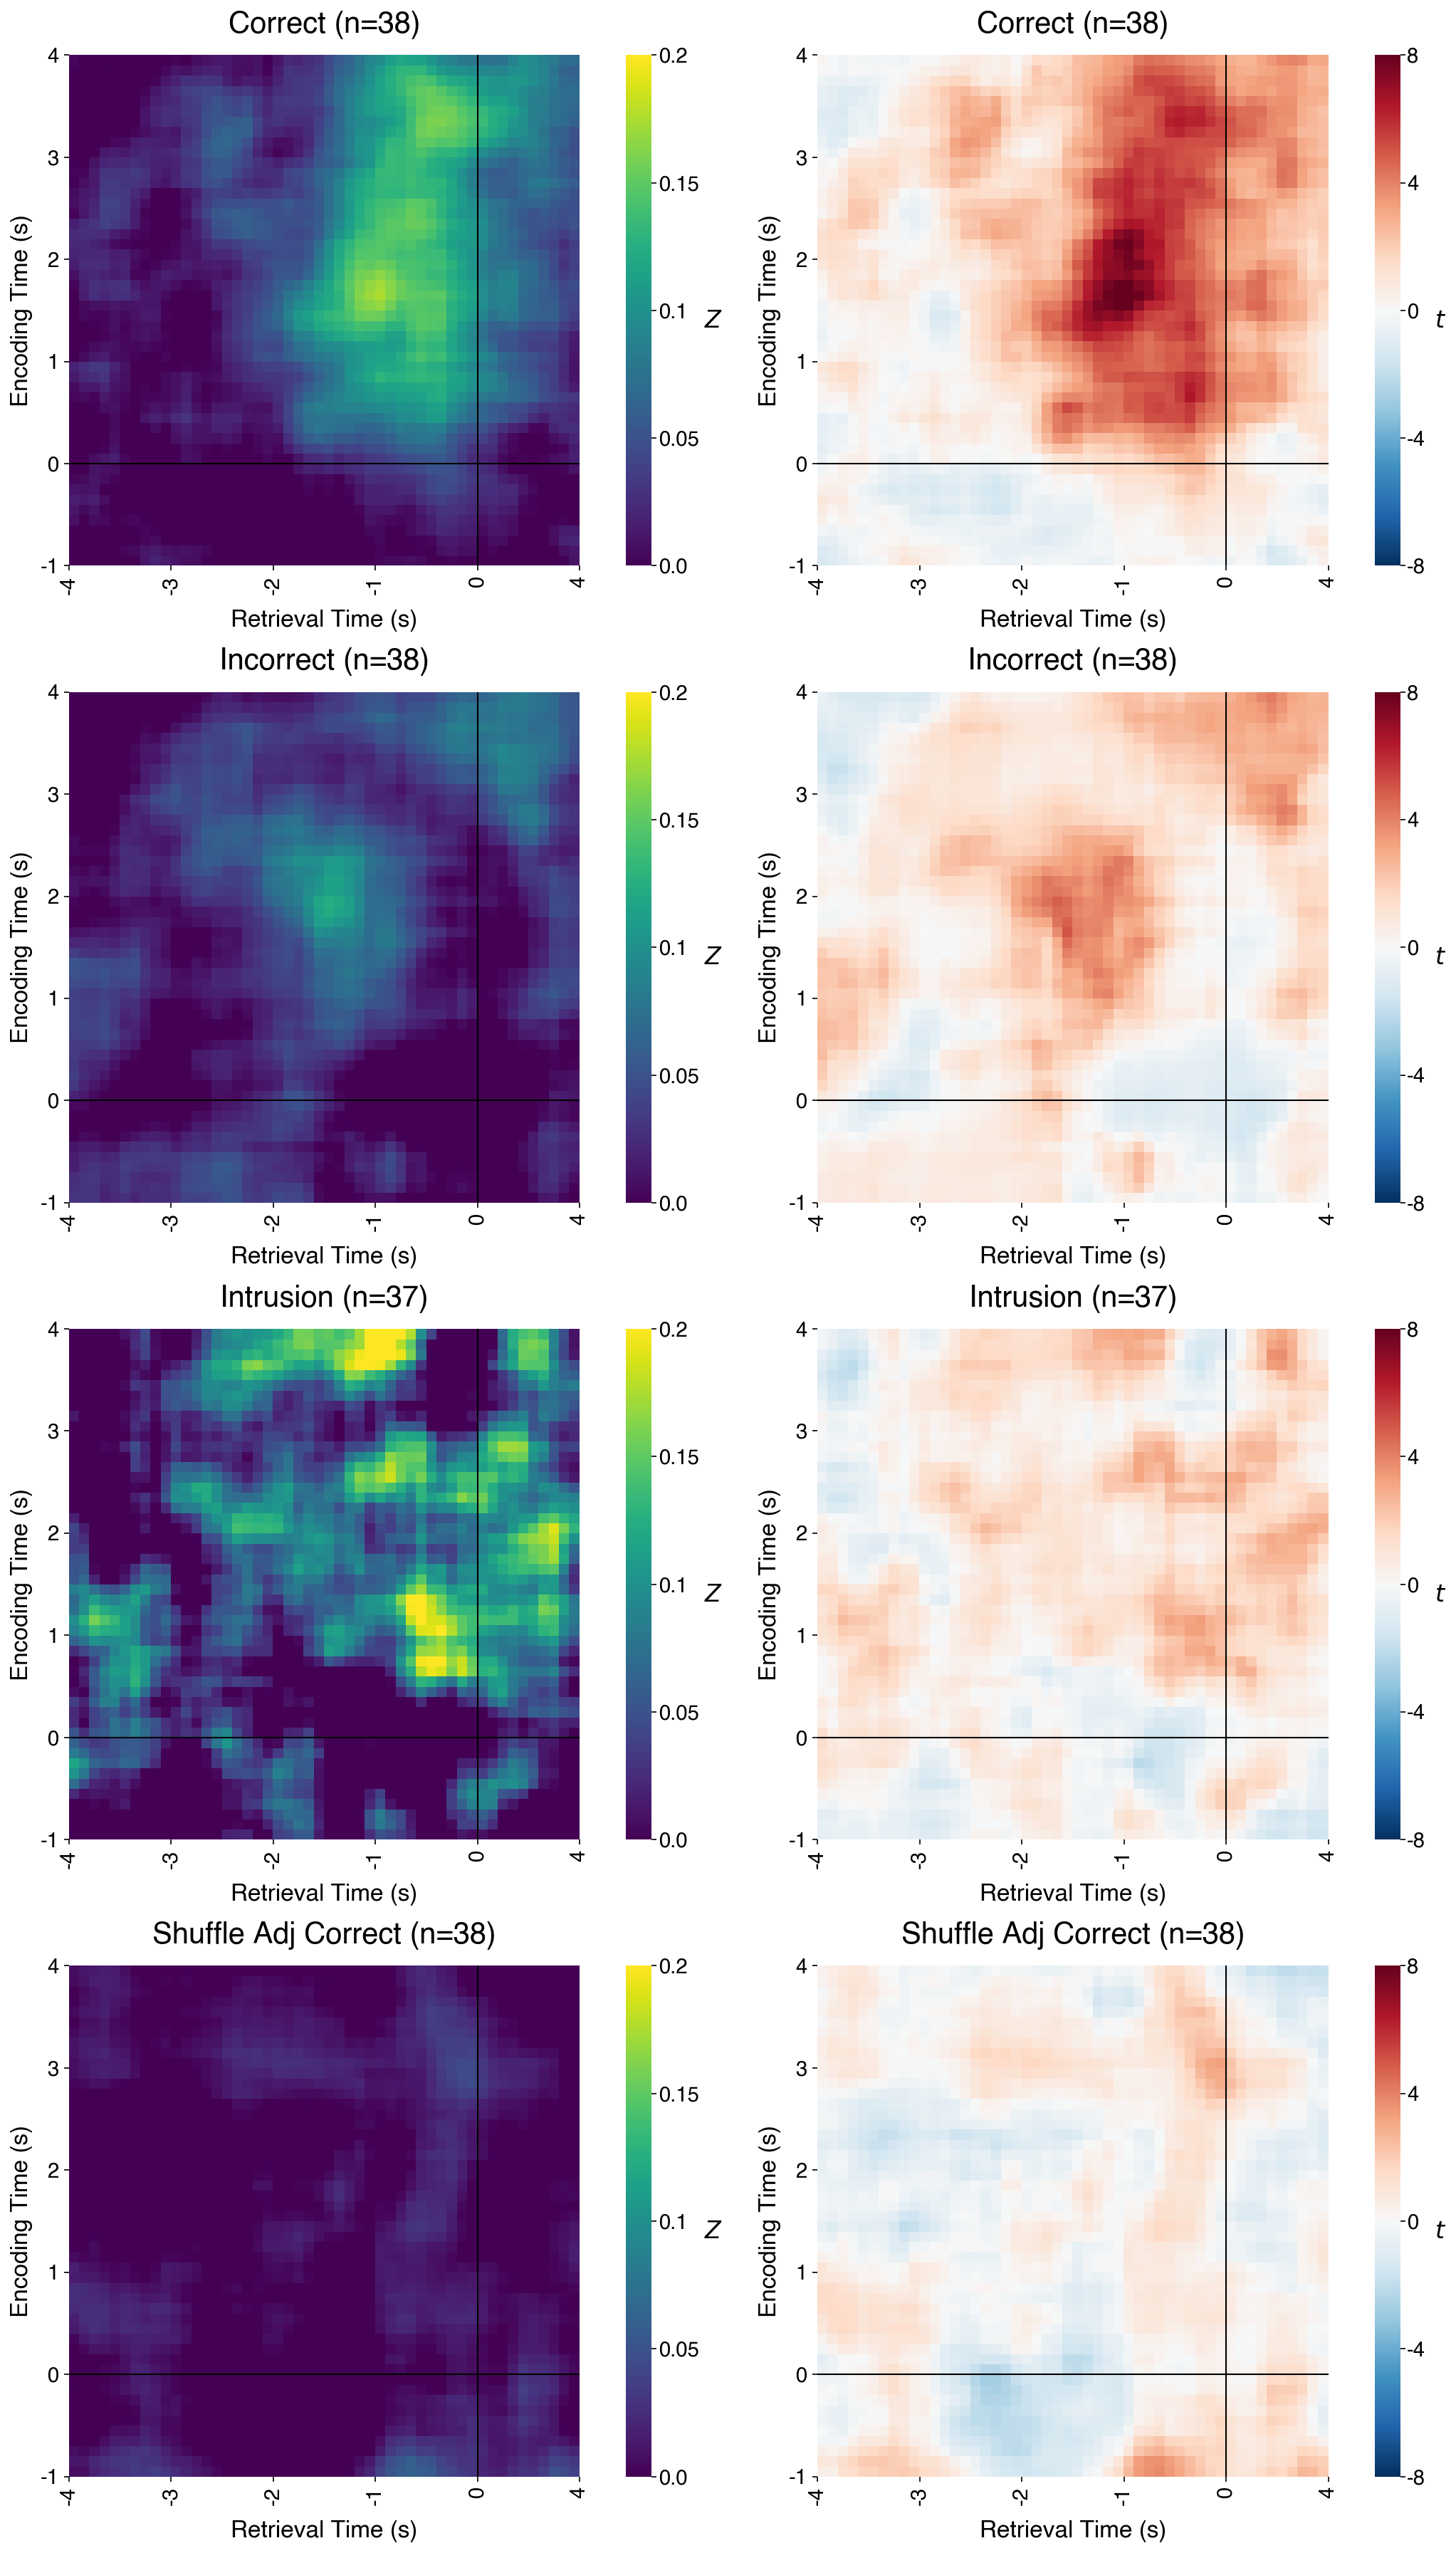

In [110]:
fig, ax = plt.subplots(4, 2, figsize=(16, 24), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16
figfontsize = 20

vmin = od([('z', 0),
           ('t', -8)])
vmax = od([('z', 0.2),
           ('t', 8)])

tests = od([('corr', (qrys['corr'], qrys['shuf_all'])),
            ('incorr', (qrys['incorr'], qrys['shuf_all'])),
            ('intru', (qrys['intru'], qrys['shuf_corr_all'])),
            ('shuf_corr_adj', (qrys['shuf_corr_adj'], qrys['shuf_corr_all']))])

for iTest, k in enumerate(tests.keys()):
    obs_qry = tests[k][0]
    null_qry = tests[k][1]
    obs = {k: np.array(v) for k, v in event_pairs.query(obs_qry).groupby('subject')['cos_sim'].apply(lambda x: list(x)).to_dict().items()}
    null = {k: np.array(v) for k, v in event_pairs.query(null_qry).groupby('subject')['cos_sim'].apply(lambda x: list(x)).to_dict().items()}
    tvals = od([])
    subjs_ = [k for k in obs if k in null]
    
    # Z-transform similarity scores across trials against means and stdevs from the null distribution.
    z_obs = od([])
    z_null = od([])
    for subj in subjs_:
        mean_ = np.expand_dims(np.mean(null[subj], axis=0), axis=0)
        std_ = np.expand_dims(np.std(null[subj], axis=0), axis=0)
        z_obs[subj] = (obs[subj] - mean_) / std_
        z_null[subj] = (null[subj] - mean_) / std_
        
    # Perform a paired t-test, across subjects, between mean obs Z-score and mean null Z-score,
    # averaging across trials within each subject, and run separately at each enc~rec timepoint.
    tvals, pvals = stats.ttest_rel(np.array([np.mean(z_obs[subj], axis=0) for subj in subjs_]), 
                                   np.array([np.mean(z_null[subj], axis=0) for subj in subjs_]), 
                                   axis=0)
    zvals = np.mean([np.mean(z_obs[subj], axis=0) for subj in subjs_], axis=0)
    print(np.min(zvals), np.max(zvals))
    
    arr = tvals
    
    i = 2 * iTest
    ax[i] = sns.heatmap(zvals, vmin=vmin['z'], vmax=vmax['z'], cmap='viridis', cbar=True, square=True, ax=ax[i])
    ax[i+1] = sns.heatmap(tvals, vmin=vmin['t'], vmax=vmax['t'], cmap='RdBu_r', cbar=True, square=True, ax=ax[i+1])
    
    for ii in (i, i+1):
        ax[ii].axvline(x=np.where(epoch_times['rec']==0)[0], color='k', linewidth=1, alpha=1)
        ax[ii].axhline(y=np.where(epoch_times['enc']==0)[0], color='k', linewidth=1, alpha=1)
        ax[ii].invert_yaxis()
        ax[ii].set_xlim([0, 50])
        ax[ii].set_xticks([0, 10, 20, 30, 40, 50])
        ax[ii].set_xticklabels((1e-3 * np.append(epoch_times['rec'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                              fontsize=tickfontsize)
        ax[ii].set_xlabel('Retrieval Time (s)', fontsize=labelfontsize, labelpad=10)
        ax[ii].set_ylim([0, 50])
        ax[ii].set_yticks([0, 10, 20, 30, 40, 50])
        ax[ii].set_yticklabels((1e-3 * np.append(epoch_times['enc'], [4000])).astype(np.int)[[0, 10, 20, 30, 40, 50]], 
                              fontsize=tickfontsize, rotation=0)
        ax[ii].set_ylabel('Encoding Time (s)', fontsize=labelfontsize, labelpad=5)
        ax[ii].set_title(titles[k].format(len(subjs_)), pad=15, fontsize=figfontsize)

        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
        
        if i == ii:
            ax[ii].set_title('')
            cbar.set_label('$Z$', fontsize=labelfontsize, rotation=0, labelpad=10)
            if vmax['z'] > 1:
                cbar.set_ticks(np.linspace(int(vmin['z']), int(vmax['z']), 5))
                cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2]
                                     for x in np.linspace(int(vmin['z']), int(vmax['z']), 5)])
            else:
                cbar.set_ticks(np.linspace(np.round(vmin['z'], 2), np.round(vmax['z'], 2), 5))
                cbar.set_ticklabels([str(np.round(x, 2)) if str(np.round(x, 2)).find(".0") == -1 else str(np.round(x, 2))
                                     for x in np.linspace(np.round(vmin['z'], 2), np.round(vmax['z'], 2), 5)])
        else:
            cbar.set_label('$t$', fontsize=labelfontsize, rotation=0, labelpad=10)
            if vmax['t'] > 1:
                cbar.set_ticks(np.linspace(int(vmin['t']), int(vmax['t']), 5))
                cbar.set_ticklabels([str(np.round(x, 1)) if str(np.round(x, 1)).find(".0") == -1 else str(np.round(x, 1))[:-2]
                                     for x in np.linspace(int(vmin['t']), int(vmax['t']), 5)])
            else:
                cbar.set_ticks(np.linspace(np.round(vmin['t'], 2), np.round(vmax['t'], 2), 5))
                cbar.set_ticklabels([str(np.round(x, 2)) if str(np.round(x, 2)).find(".0") == -1 else str(np.round(x, 2))
                                     for x in np.linspace(np.round(vmin['t'], 2), np.round(vmax['t'], 2), 5)])


fig.tight_layout(w_pad=-12)